# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Plot Style

In [3]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
            nn.Sigmoid()
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=2, bias=True)
    (7): Sigmoid()
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.1567
Epoch 1/200, Iteration 2/12, Loss: 1.2754
Epoch 1/200, Iteration 3/12, Loss: 0.9234
Epoch 1/200, Iteration 4/12, Loss: 0.6342
Epoch 1/200, Iteration 5/12, Loss: 0.5120
Epoch 1/200, Iteration 6/12, Loss: 0.3775
Epoch 1/200, Iteration 7/12, Loss: 0.5167
Epoch 1/200, Iteration 8/12, Loss: 0.4250
Epoch 1/200, Iteration 9/12, Loss: 0.7567
Epoch 1/200, Iteration 10/12, Loss: 0.5600
Epoch 1/200, Iteration 11/12, Loss: 0.5994
Epoch 1/200, Iteration 12/12, Loss: 0.6680
Epoch 1/200, Iteration 13/12, Loss: 0.3821
Train Error: 
 Accuracy: 38.25%, Avg loss: 0.570438, MRE: 0.637814, MAE: 0.079184 

Test Error: 
 Accuracy: 41.5%, Avg loss: 0.484525, MRE: 0.502337, MAE: 0.068436 

Epoch 2/200, Iteration 1/12, Loss: 0.4622
Epoch 2/200, Iteration 2/12, Loss: 0.6226
Epoch 2/200, Iteration 3/12, Loss: 0.4635
Epoch 2/200, Iteration 4/12, Loss: 0.5640
Epoch 2/200, Iteration 5/12, Loss: 0.5720
Epoch 2/200, Iteration 6/12, Loss: 0.6715
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 33.5%, Avg loss: 0.606410, MRE: 0.648970, MAE: 0.083399 

Test Error: 
 Accuracy: 33.5%, Avg loss: 0.500084, MRE: 0.510087, MAE: 0.070306 

Epoch 13/200, Iteration 1/12, Loss: 0.6370
Epoch 13/200, Iteration 2/12, Loss: 0.5726
Epoch 13/200, Iteration 3/12, Loss: 0.6367
Epoch 13/200, Iteration 4/12, Loss: 0.6023
Epoch 13/200, Iteration 5/12, Loss: 0.6241
Epoch 13/200, Iteration 6/12, Loss: 0.6150
Epoch 13/200, Iteration 7/12, Loss: 0.5604
Epoch 13/200, Iteration 8/12, Loss: 0.7382
Epoch 13/200, Iteration 9/12, Loss: 0.5532
Epoch 13/200, Iteration 10/12, Loss: 0.6309
Epoch 13/200, Iteration 11/12, Loss: 0.5615
Epoch 13/200, Iteration 12/12, Loss: 0.4647
Epoch 13/200, Iteration 13/12, Loss: 0.5970
Train Error: 
 Accuracy: 33.88%, Avg loss: 0.591579, MRE: 0.644076, MAE: 0.081929 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.500545, MRE: 0.510367, MAE: 0.070355 

Epoch 14/200, Iteration 1/12, Loss: 0.8072
Epoch 14/200, Iteration 2/12, Loss: 0.6846
Epoch 14/200, Iterat

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.584044, MRE: 0.644295, MAE: 0.081263 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497302, MRE: 0.508862, MAE: 0.070023 

Epoch 25/200, Iteration 1/12, Loss: 0.5539
Epoch 25/200, Iteration 2/12, Loss: 0.5599
Epoch 25/200, Iteration 3/12, Loss: 0.5817
Epoch 25/200, Iteration 4/12, Loss: 0.6320
Epoch 25/200, Iteration 5/12, Loss: 0.5318
Epoch 25/200, Iteration 6/12, Loss: 0.6834
Epoch 25/200, Iteration 7/12, Loss: 0.5338
Epoch 25/200, Iteration 8/12, Loss: 0.4670
Epoch 25/200, Iteration 9/12, Loss: 0.5482
Epoch 25/200, Iteration 10/12, Loss: 0.5670
Epoch 25/200, Iteration 11/12, Loss: 0.7281
Epoch 25/200, Iteration 12/12, Loss: 0.6166
Epoch 25/200, Iteration 13/12, Loss: 0.5741
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.586741, MRE: 0.651162, MAE: 0.081334 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497294, MRE: 0.508866, MAE: 0.070026 

Epoch 26/200, Iteration 1/12, Loss: 0.6889
Epoch 26/200, Iteration 2/12, Loss: 0.5078
Epoch 26/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.580941, MRE: 0.719338, MAE: 0.080868 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497094, MRE: 0.508830, MAE: 0.069992 

Epoch 37/200, Iteration 1/12, Loss: 0.4984
Epoch 37/200, Iteration 2/12, Loss: 0.5936
Epoch 37/200, Iteration 3/12, Loss: 0.4945
Epoch 37/200, Iteration 4/12, Loss: 0.4900
Epoch 37/200, Iteration 5/12, Loss: 0.5862
Epoch 37/200, Iteration 6/12, Loss: 0.5527
Epoch 37/200, Iteration 7/12, Loss: 0.5981
Epoch 37/200, Iteration 8/12, Loss: 0.5545
Epoch 37/200, Iteration 9/12, Loss: 0.5432
Epoch 37/200, Iteration 10/12, Loss: 0.6109
Epoch 37/200, Iteration 11/12, Loss: 0.6836
Epoch 37/200, Iteration 12/12, Loss: 0.7987
Epoch 37/200, Iteration 13/12, Loss: 0.5713
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.573182, MRE: 0.638683, MAE: 0.079953 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497090, MRE: 0.508828, MAE: 0.069991 

Epoch 38/200, Iteration 1/12, Loss: 0.6157
Epoch 38/200, Iteration 2/12, Loss: 0.5676
Epoch 38/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.579463, MRE: 0.643125, MAE: 0.080685 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497039, MRE: 0.508804, MAE: 0.069978 

Epoch 49/200, Iteration 1/12, Loss: 0.7162
Epoch 49/200, Iteration 2/12, Loss: 0.6363
Epoch 49/200, Iteration 3/12, Loss: 0.5645
Epoch 49/200, Iteration 4/12, Loss: 0.5769
Epoch 49/200, Iteration 5/12, Loss: 0.4574
Epoch 49/200, Iteration 6/12, Loss: 0.6340
Epoch 49/200, Iteration 7/12, Loss: 0.6135
Epoch 49/200, Iteration 8/12, Loss: 0.5264
Epoch 49/200, Iteration 9/12, Loss: 0.6486
Epoch 49/200, Iteration 10/12, Loss: 0.5516
Epoch 49/200, Iteration 11/12, Loss: 0.3855
Epoch 49/200, Iteration 12/12, Loss: 0.6591
Epoch 49/200, Iteration 13/12, Loss: 0.6395
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.587996, MRE: 0.646744, MAE: 0.081356 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497038, MRE: 0.508804, MAE: 0.069978 

Epoch 50/200, Iteration 1/12, Loss: 0.5562
Epoch 50/200, Iteration 2/12, Loss: 0.5247
Epoch 50/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.592969, MRE: 0.655556, MAE: 0.081762 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497030, MRE: 0.508800, MAE: 0.069975 

Epoch 61/200, Iteration 1/12, Loss: 0.5444
Epoch 61/200, Iteration 2/12, Loss: 0.5518
Epoch 61/200, Iteration 3/12, Loss: 0.7427
Epoch 61/200, Iteration 4/12, Loss: 0.5204
Epoch 61/200, Iteration 5/12, Loss: 0.5919
Epoch 61/200, Iteration 6/12, Loss: 0.5576
Epoch 61/200, Iteration 7/12, Loss: 0.8110
Epoch 61/200, Iteration 8/12, Loss: 0.5686
Epoch 61/200, Iteration 9/12, Loss: 0.3576
Epoch 61/200, Iteration 10/12, Loss: 0.6113
Epoch 61/200, Iteration 11/12, Loss: 0.5553
Epoch 61/200, Iteration 12/12, Loss: 0.6205
Epoch 61/200, Iteration 13/12, Loss: 0.5138
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.574317, MRE: 0.632457, MAE: 0.080322 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497030, MRE: 0.508800, MAE: 0.069975 

Epoch 62/200, Iteration 1/12, Loss: 0.5609
Epoch 62/200, Iteration 2/12, Loss: 0.7058
Epoch 62/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.580655, MRE: 0.643152, MAE: 0.080724 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 73/200, Iteration 1/12, Loss: 0.6443
Epoch 73/200, Iteration 2/12, Loss: 0.4771
Epoch 73/200, Iteration 3/12, Loss: 0.5338
Epoch 73/200, Iteration 4/12, Loss: 0.5509
Epoch 73/200, Iteration 5/12, Loss: 0.6000
Epoch 73/200, Iteration 6/12, Loss: 0.5899
Epoch 73/200, Iteration 7/12, Loss: 0.4372
Epoch 73/200, Iteration 8/12, Loss: 0.5659
Epoch 73/200, Iteration 9/12, Loss: 0.7039
Epoch 73/200, Iteration 10/12, Loss: 0.6799
Epoch 73/200, Iteration 11/12, Loss: 0.5824
Epoch 73/200, Iteration 12/12, Loss: 0.6194
Epoch 73/200, Iteration 13/12, Loss: 0.6102
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.574873, MRE: 0.635727, MAE: 0.080223 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 74/200, Iteration 1/12, Loss: 0.6895
Epoch 74/200, Iteration 2/12, Loss: 0.6538
Epoch 74/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.585817, MRE: 0.648101, MAE: 0.080973 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 85/200, Iteration 1/12, Loss: 0.5848
Epoch 85/200, Iteration 2/12, Loss: 0.5585
Epoch 85/200, Iteration 3/12, Loss: 0.4628
Epoch 85/200, Iteration 4/12, Loss: 0.5920
Epoch 85/200, Iteration 5/12, Loss: 0.5053
Epoch 85/200, Iteration 6/12, Loss: 0.7497
Epoch 85/200, Iteration 7/12, Loss: 0.6755
Epoch 85/200, Iteration 8/12, Loss: 0.5937
Epoch 85/200, Iteration 9/12, Loss: 0.5731
Epoch 85/200, Iteration 10/12, Loss: 0.5706
Epoch 85/200, Iteration 11/12, Loss: 0.6369
Epoch 85/200, Iteration 12/12, Loss: 0.5021
Epoch 85/200, Iteration 13/12, Loss: 0.5698
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.576268, MRE: 0.633698, MAE: 0.080681 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 86/200, Iteration 1/12, Loss: 0.5041
Epoch 86/200, Iteration 2/12, Loss: 0.5615
Epoch 86/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.582730, MRE: 0.654531, MAE: 0.080763 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 97/200, Iteration 1/12, Loss: 0.5473
Epoch 97/200, Iteration 2/12, Loss: 0.6177
Epoch 97/200, Iteration 3/12, Loss: 0.5372
Epoch 97/200, Iteration 4/12, Loss: 0.5352
Epoch 97/200, Iteration 5/12, Loss: 0.3774
Epoch 97/200, Iteration 6/12, Loss: 0.5761
Epoch 97/200, Iteration 7/12, Loss: 0.6588
Epoch 97/200, Iteration 8/12, Loss: 0.6036
Epoch 97/200, Iteration 9/12, Loss: 0.6632
Epoch 97/200, Iteration 10/12, Loss: 0.6991
Epoch 97/200, Iteration 11/12, Loss: 0.5633
Epoch 97/200, Iteration 12/12, Loss: 0.5961
Epoch 97/200, Iteration 13/12, Loss: 0.6294
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.587506, MRE: 0.649502, MAE: 0.081236 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 98/200, Iteration 1/12, Loss: 0.6002
Epoch 98/200, Iteration 2/12, Loss: 0.5680
Epoch 98/200, Itera

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.583440, MRE: 0.649550, MAE: 0.080778 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 109/200, Iteration 1/12, Loss: 0.6187
Epoch 109/200, Iteration 2/12, Loss: 0.5232
Epoch 109/200, Iteration 3/12, Loss: 0.5445
Epoch 109/200, Iteration 4/12, Loss: 0.7619
Epoch 109/200, Iteration 5/12, Loss: 0.5785
Epoch 109/200, Iteration 6/12, Loss: 0.6661
Epoch 109/200, Iteration 7/12, Loss: 0.4850
Epoch 109/200, Iteration 8/12, Loss: 0.7256
Epoch 109/200, Iteration 9/12, Loss: 0.6061
Epoch 109/200, Iteration 10/12, Loss: 0.5182
Epoch 109/200, Iteration 11/12, Loss: 0.4447
Epoch 109/200, Iteration 12/12, Loss: 0.5113
Epoch 109/200, Iteration 13/12, Loss: 0.6119
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.580858, MRE: 0.641643, MAE: 0.080707 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497029, MRE: 0.508799, MAE: 0.069975 

Epoch 110/200, Iteration 1/12, Loss: 0.5007
Epoch 110/200, Iteration 2/12, Loss: 0.6246
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.583087, MRE: 0.642967, MAE: 0.080927 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 121/200, Iteration 1/12, Loss: 0.5790
Epoch 121/200, Iteration 2/12, Loss: 0.7193
Epoch 121/200, Iteration 3/12, Loss: 0.6687
Epoch 121/200, Iteration 4/12, Loss: 0.5948
Epoch 121/200, Iteration 5/12, Loss: 0.4469
Epoch 121/200, Iteration 6/12, Loss: 0.4876
Epoch 121/200, Iteration 7/12, Loss: 0.6278
Epoch 121/200, Iteration 8/12, Loss: 0.6357
Epoch 121/200, Iteration 9/12, Loss: 0.4726
Epoch 121/200, Iteration 10/12, Loss: 0.6497
Epoch 121/200, Iteration 11/12, Loss: 0.5100
Epoch 121/200, Iteration 12/12, Loss: 0.6535
Epoch 121/200, Iteration 13/12, Loss: 0.4884
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.580178, MRE: 0.642733, MAE: 0.080599 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 122/200, Iteration 1/12, Loss: 0.7440
Epoch 122/200, Iteration 2/12, Loss: 0.6097
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.588043, MRE: 0.653976, MAE: 0.081223 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 133/200, Iteration 1/12, Loss: 0.6305
Epoch 133/200, Iteration 2/12, Loss: 0.5997
Epoch 133/200, Iteration 3/12, Loss: 0.4683
Epoch 133/200, Iteration 4/12, Loss: 0.6307
Epoch 133/200, Iteration 5/12, Loss: 0.7243
Epoch 133/200, Iteration 6/12, Loss: 0.5536
Epoch 133/200, Iteration 7/12, Loss: 0.6951
Epoch 133/200, Iteration 8/12, Loss: 0.6545
Epoch 133/200, Iteration 9/12, Loss: 0.5224
Epoch 133/200, Iteration 10/12, Loss: 0.5741
Epoch 133/200, Iteration 11/12, Loss: 0.5377
Epoch 133/200, Iteration 12/12, Loss: 0.5008
Epoch 133/200, Iteration 13/12, Loss: 0.3964
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.583937, MRE: 0.641355, MAE: 0.080998 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 134/200, Iteration 1/12, Loss: 0.5971
Epoch 134/200, Iteration 2/12, Loss: 0.4656
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.582261, MRE: 0.641394, MAE: 0.080846 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 145/200, Iteration 1/12, Loss: 0.7593
Epoch 145/200, Iteration 2/12, Loss: 0.4052
Epoch 145/200, Iteration 3/12, Loss: 0.5726
Epoch 145/200, Iteration 4/12, Loss: 0.6280
Epoch 145/200, Iteration 5/12, Loss: 0.6181
Epoch 145/200, Iteration 6/12, Loss: 0.5298
Epoch 145/200, Iteration 7/12, Loss: 0.5598
Epoch 145/200, Iteration 8/12, Loss: 0.6298
Epoch 145/200, Iteration 9/12, Loss: 0.5372
Epoch 145/200, Iteration 10/12, Loss: 0.5774
Epoch 145/200, Iteration 11/12, Loss: 0.6475
Epoch 145/200, Iteration 12/12, Loss: 0.5427
Epoch 145/200, Iteration 13/12, Loss: 0.5650
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.584003, MRE: 0.645659, MAE: 0.080958 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 146/200, Iteration 1/12, Loss: 0.6411
Epoch 146/200, Iteration 2/12, Loss: 0.5816
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.588095, MRE: 0.646551, MAE: 0.081606 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 157/200, Iteration 1/12, Loss: 0.5770
Epoch 157/200, Iteration 2/12, Loss: 0.5844
Epoch 157/200, Iteration 3/12, Loss: 0.3879
Epoch 157/200, Iteration 4/12, Loss: 0.4943
Epoch 157/200, Iteration 5/12, Loss: 0.6412
Epoch 157/200, Iteration 6/12, Loss: 0.7044
Epoch 157/200, Iteration 7/12, Loss: 0.4710
Epoch 157/200, Iteration 8/12, Loss: 0.6855
Epoch 157/200, Iteration 9/12, Loss: 0.4617
Epoch 157/200, Iteration 10/12, Loss: 0.6239
Epoch 157/200, Iteration 11/12, Loss: 0.6428
Epoch 157/200, Iteration 12/12, Loss: 0.6211
Epoch 157/200, Iteration 13/12, Loss: 0.7892
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.575135, MRE: 0.635232, MAE: 0.080357 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497028, MRE: 0.508799, MAE: 0.069975 

Epoch 158/200, Iteration 1/12, Loss: 0.6468
Epoch 158/200, Iteration 2/12, Loss: 0.6108
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.571807, MRE: 0.631994, MAE: 0.080061 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508799, MAE: 0.069975 

Epoch 169/200, Iteration 1/12, Loss: 0.6436
Epoch 169/200, Iteration 2/12, Loss: 0.5546
Epoch 169/200, Iteration 3/12, Loss: 0.5986
Epoch 169/200, Iteration 4/12, Loss: 0.6437
Epoch 169/200, Iteration 5/12, Loss: 0.6945
Epoch 169/200, Iteration 6/12, Loss: 0.5494
Epoch 169/200, Iteration 7/12, Loss: 0.4963
Epoch 169/200, Iteration 8/12, Loss: 0.4738
Epoch 169/200, Iteration 9/12, Loss: 0.7759
Epoch 169/200, Iteration 10/12, Loss: 0.4798
Epoch 169/200, Iteration 11/12, Loss: 0.7351
Epoch 169/200, Iteration 12/12, Loss: 0.4087
Epoch 169/200, Iteration 13/12, Loss: 0.4717
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.585887, MRE: 0.646993, MAE: 0.081269 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508799, MAE: 0.069975 

Epoch 170/200, Iteration 1/12, Loss: 0.6074
Epoch 170/200, Iteration 2/12, Loss: 0.5842
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.572559, MRE: 0.633179, MAE: 0.080053 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508798, MAE: 0.069975 

Epoch 181/200, Iteration 1/12, Loss: 0.5988
Epoch 181/200, Iteration 2/12, Loss: 0.7086
Epoch 181/200, Iteration 3/12, Loss: 0.5882
Epoch 181/200, Iteration 4/12, Loss: 0.4806
Epoch 181/200, Iteration 5/12, Loss: 0.6129
Epoch 181/200, Iteration 6/12, Loss: 0.5397
Epoch 181/200, Iteration 7/12, Loss: 0.5585
Epoch 181/200, Iteration 8/12, Loss: 0.6231
Epoch 181/200, Iteration 9/12, Loss: 0.6104
Epoch 181/200, Iteration 10/12, Loss: 0.6162
Epoch 181/200, Iteration 11/12, Loss: 0.5776
Epoch 181/200, Iteration 12/12, Loss: 0.4513
Epoch 181/200, Iteration 13/12, Loss: 0.6478
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.592624, MRE: 0.646453, MAE: 0.081570 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508798, MAE: 0.069975 

Epoch 182/200, Iteration 1/12, Loss: 0.6575
Epoch 182/200, Iteration 2/12, Loss: 0.5627
Epoc

Train Error: 
 Accuracy: 34.62%, Avg loss: 0.581327, MRE: 0.653971, MAE: 0.080465 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508798, MAE: 0.069974 

Epoch 193/200, Iteration 1/12, Loss: 0.6331
Epoch 193/200, Iteration 2/12, Loss: 0.5870
Epoch 193/200, Iteration 3/12, Loss: 0.5041
Epoch 193/200, Iteration 4/12, Loss: 0.6240
Epoch 193/200, Iteration 5/12, Loss: 0.5234
Epoch 193/200, Iteration 6/12, Loss: 0.5460
Epoch 193/200, Iteration 7/12, Loss: 0.5894
Epoch 193/200, Iteration 8/12, Loss: 0.7061
Epoch 193/200, Iteration 9/12, Loss: 0.5686
Epoch 193/200, Iteration 10/12, Loss: 0.5939
Epoch 193/200, Iteration 11/12, Loss: 0.4734
Epoch 193/200, Iteration 12/12, Loss: 0.6478
Epoch 193/200, Iteration 13/12, Loss: 0.5862
Train Error: 
 Accuracy: 34.62%, Avg loss: 0.589988, MRE: 0.730526, MAE: 0.081053 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.497027, MRE: 0.508798, MAE: 0.069974 

Epoch 194/200, Iteration 1/12, Loss: 0.7876
Epoch 194/200, Iteration 2/12, Loss: 0.6151
Epoc

#### Plots loss vs Epoch

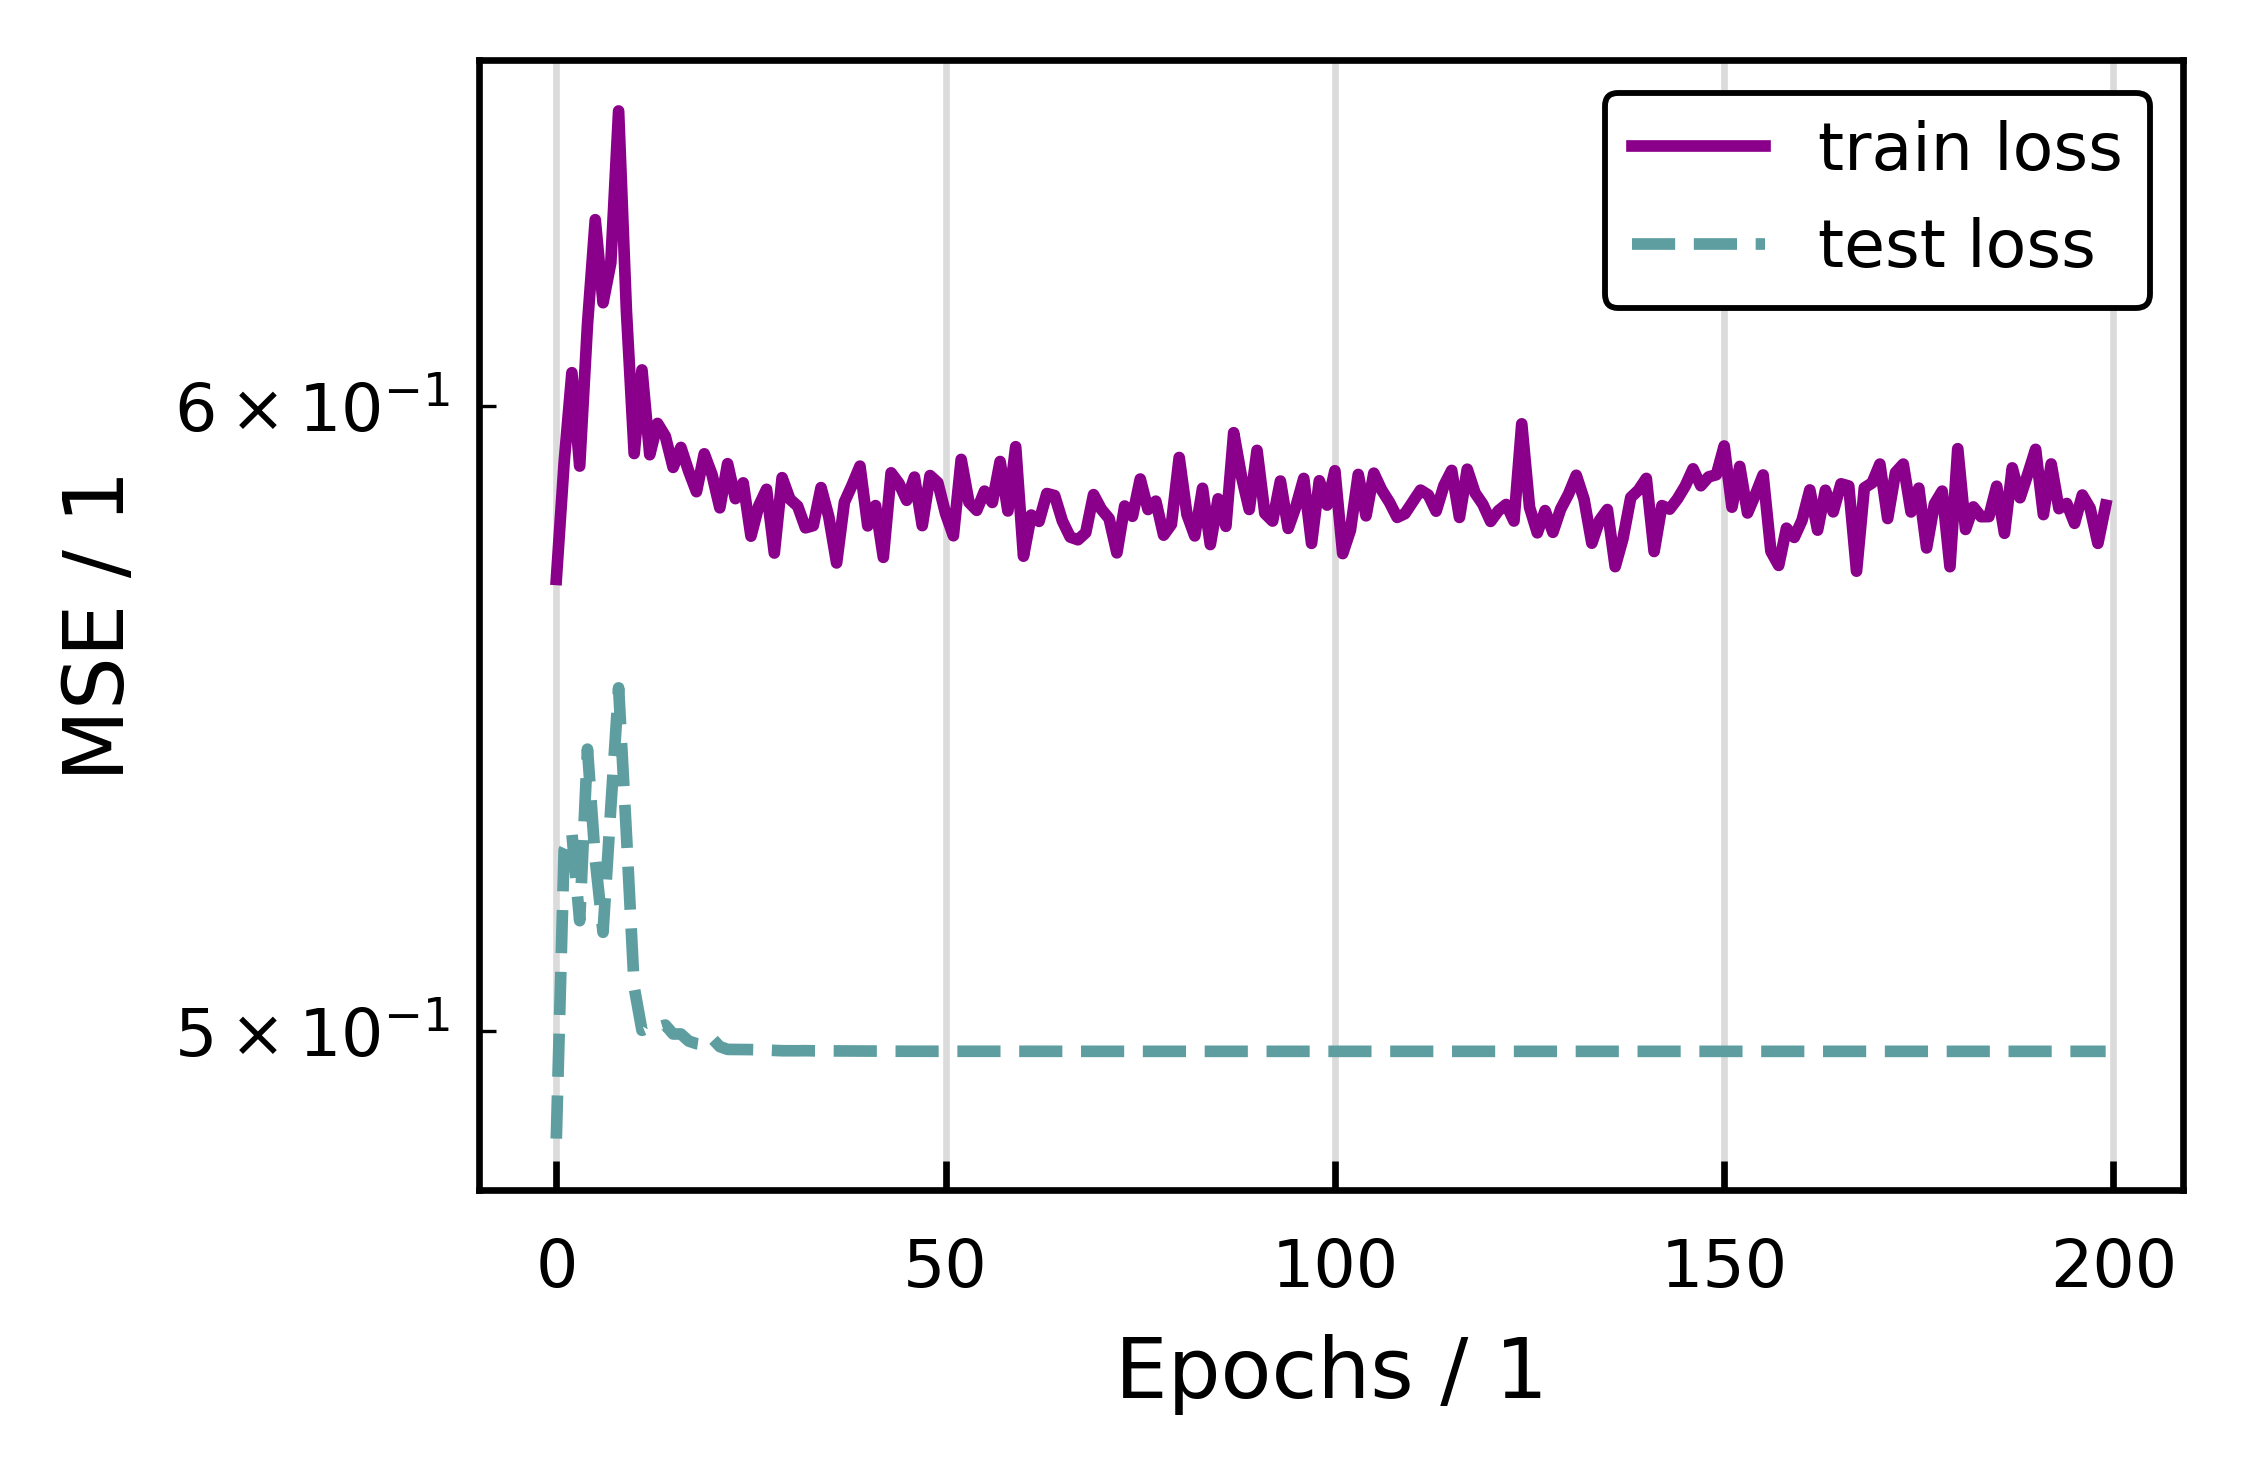

In [11]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss,'--', label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = 'Epochs / 1', ylabel = 'MSE / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)
#ax.set(xlim=(0,200), ylim=(1e-5,1e-1))

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_001_learningcurve.png', bbox_inches = 'tight')
#np.savez('data/models/hyperparams/loss_005_020.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.3932175965077398 , R^2(NH3) = 0.43895619367806593
Test Dataset: R^2(H2) = 0.39880235963571664 , R^2(NH3) = 0.4557392029270836
Train R^2 gemittelt:  0.41608689509290286
Test R^2 gemittelt:  0.4272707812814001
Max Error Training: |x_H2 - x_H2,pred| = 0.46070210285250435 , |x_NH3 - x_NH3,pred| = 0.1954400372661963
Max Error Test: |x_H2 - x_H2,pred| = 0.42272607303508947 , |x_NH3 - x_NH3,pred| = 0.18019315581847556


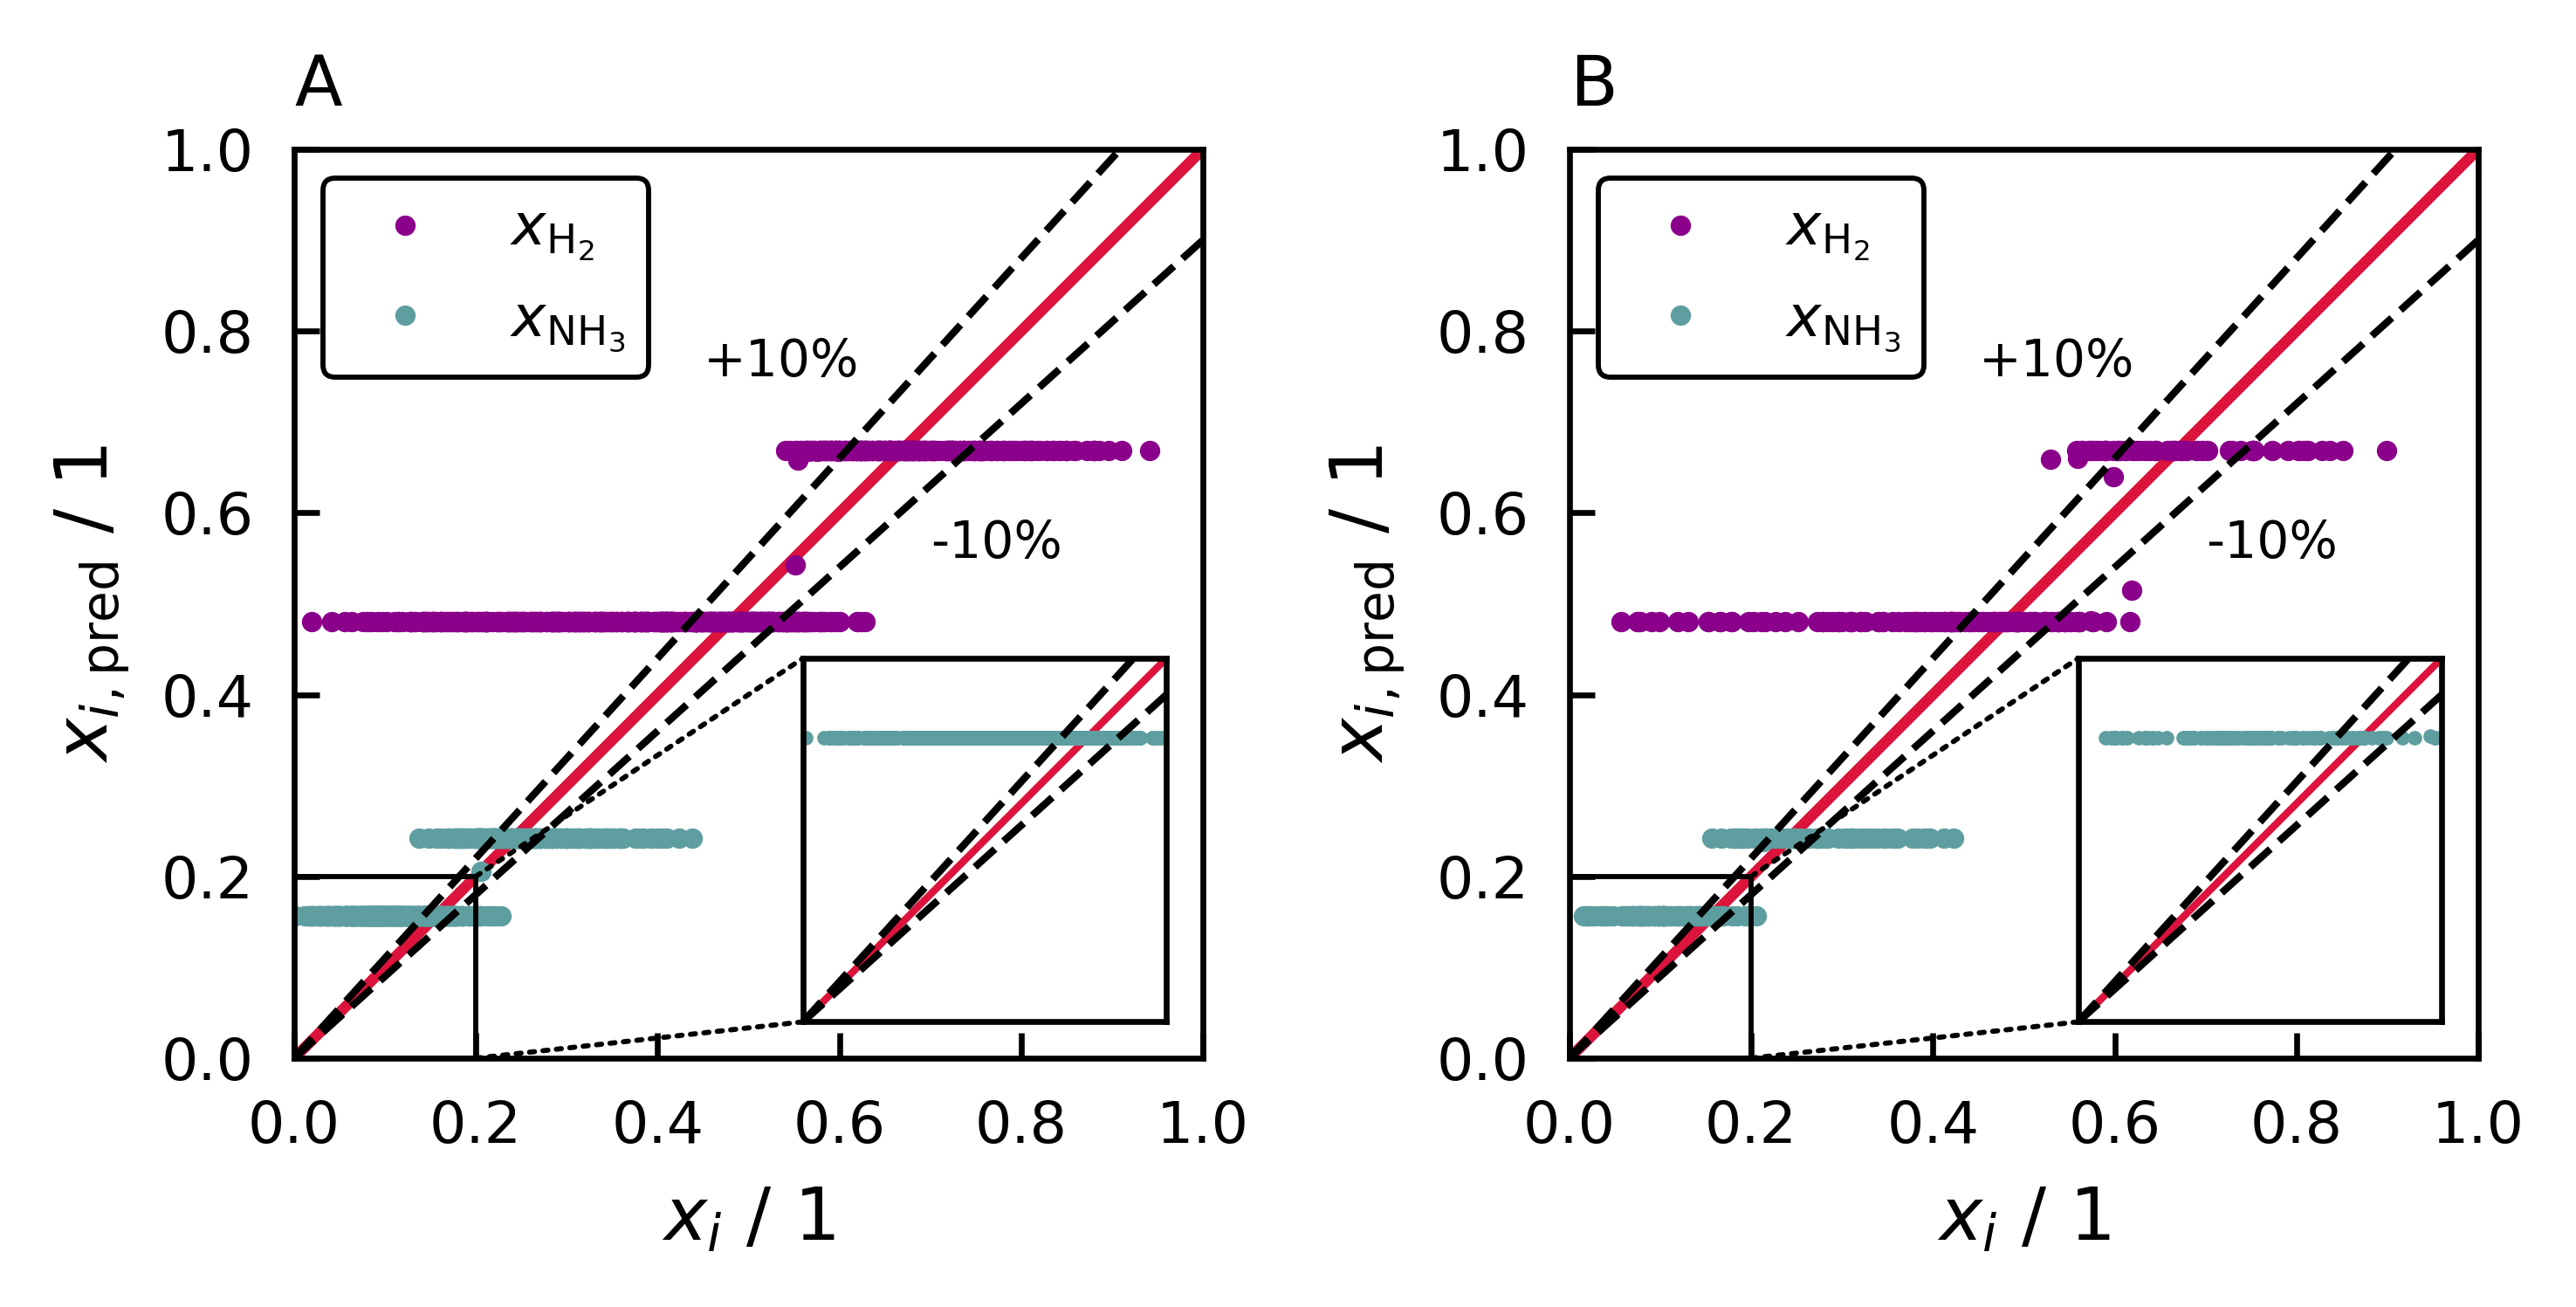

In [13]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Train R^2 gemittelt: ', (r2(x_H2_real,x_H2_pred)+r2(x_NH3_real,x_NH3_pred))/2)
print('Test R^2 gemittelt: ', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2)#, figsize =(13*cm,6.5*cm))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")


ax[0].plot(x_H2_real, x_H2_pred, '.', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[0].transAxes, zorder=1)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line

ax[0].text(0.45, 0.75, '+10%', fontsize=7)
ax[0].text(0.7, 0.55, '-10%', fontsize=7)
ax[0].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('A', loc='left')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin0 = ax[0].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin0.plot(x_H2_real, x_H2_pred, '.', markersize = 4)
axin0.plot(x_NH3_real, x_NH3_pred, '.', markersize = 4)
axin0.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin0.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box2= ax[0].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[0], axesB=axin0,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[0].add_patch(cp1)
ax[0].add_patch(cp2)


# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "-", color = 'crimson',lw=1.5 ,transform=ax[1].transAxes, zorder=1)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax[1].text(0.45, 0.75, '+10%', fontsize=7)
ax[1].text(0.7, 0.55, '-10%', fontsize=7)
ax[1].set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('B', loc='left')
ax[1].legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax[1].inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax[1].indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax[1], axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax[1].add_patch(cp1)
ax[1].add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [14]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_002_parity.png', bbox_inches = 'tight')

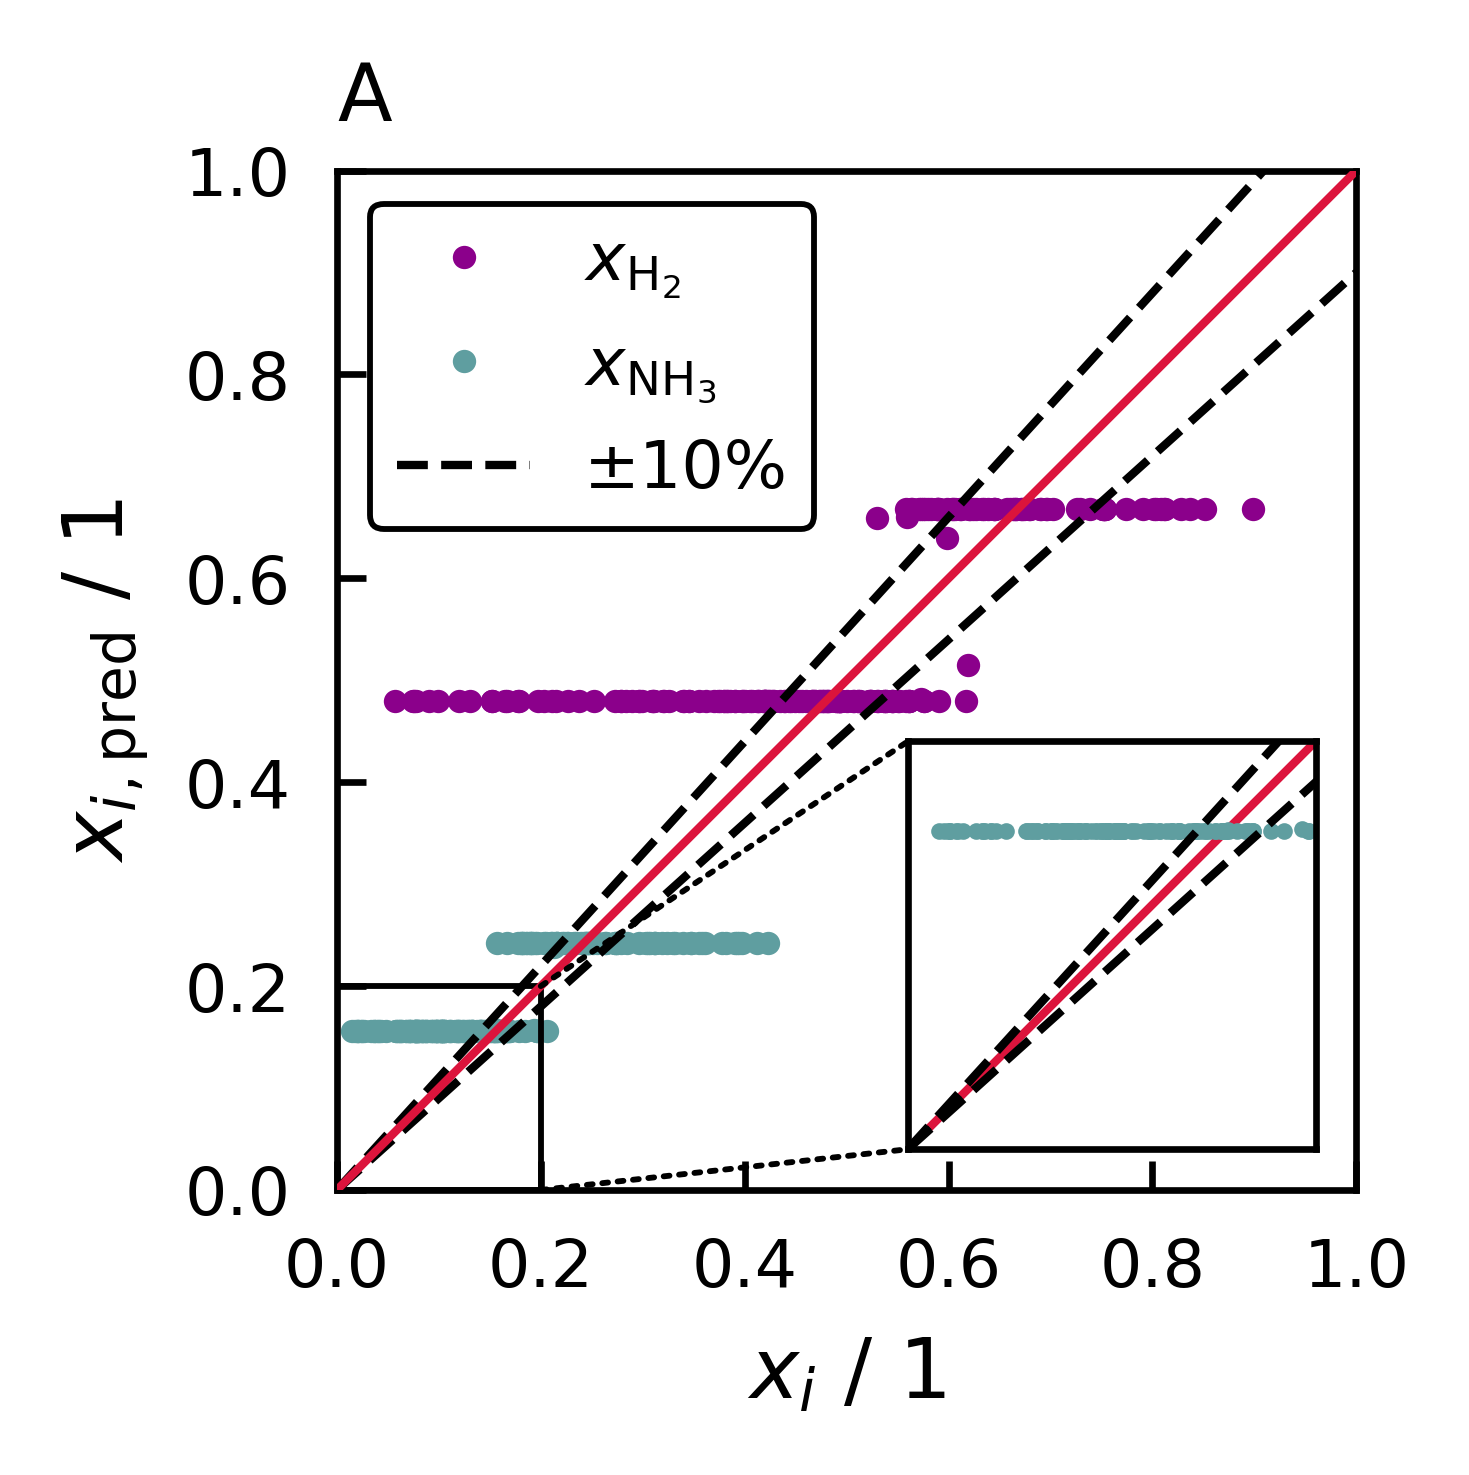

In [15]:
fig,ax = plt.subplots(figsize =(6.5*cm,6.5*cm))
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1 ,transform=ax.transAxes, zorder=10)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1]*1.1], "k--", lw=1, label = ('\xb1' '10%')) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1]*0.9], "k--",lw=1) # Error line
# ax.text(0.45, 0.75, '+10%', fontsize=7)
# ax.text(0.7, 0.55, '-10%', fontsize=7)
ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('A', loc='left')
ax.legend()

#inset axes
x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax.inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax.add_patch(cp1)
ax.add_patch(cp2)

#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [16]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_020_parity_best.png', bbox_inches = 'tight')

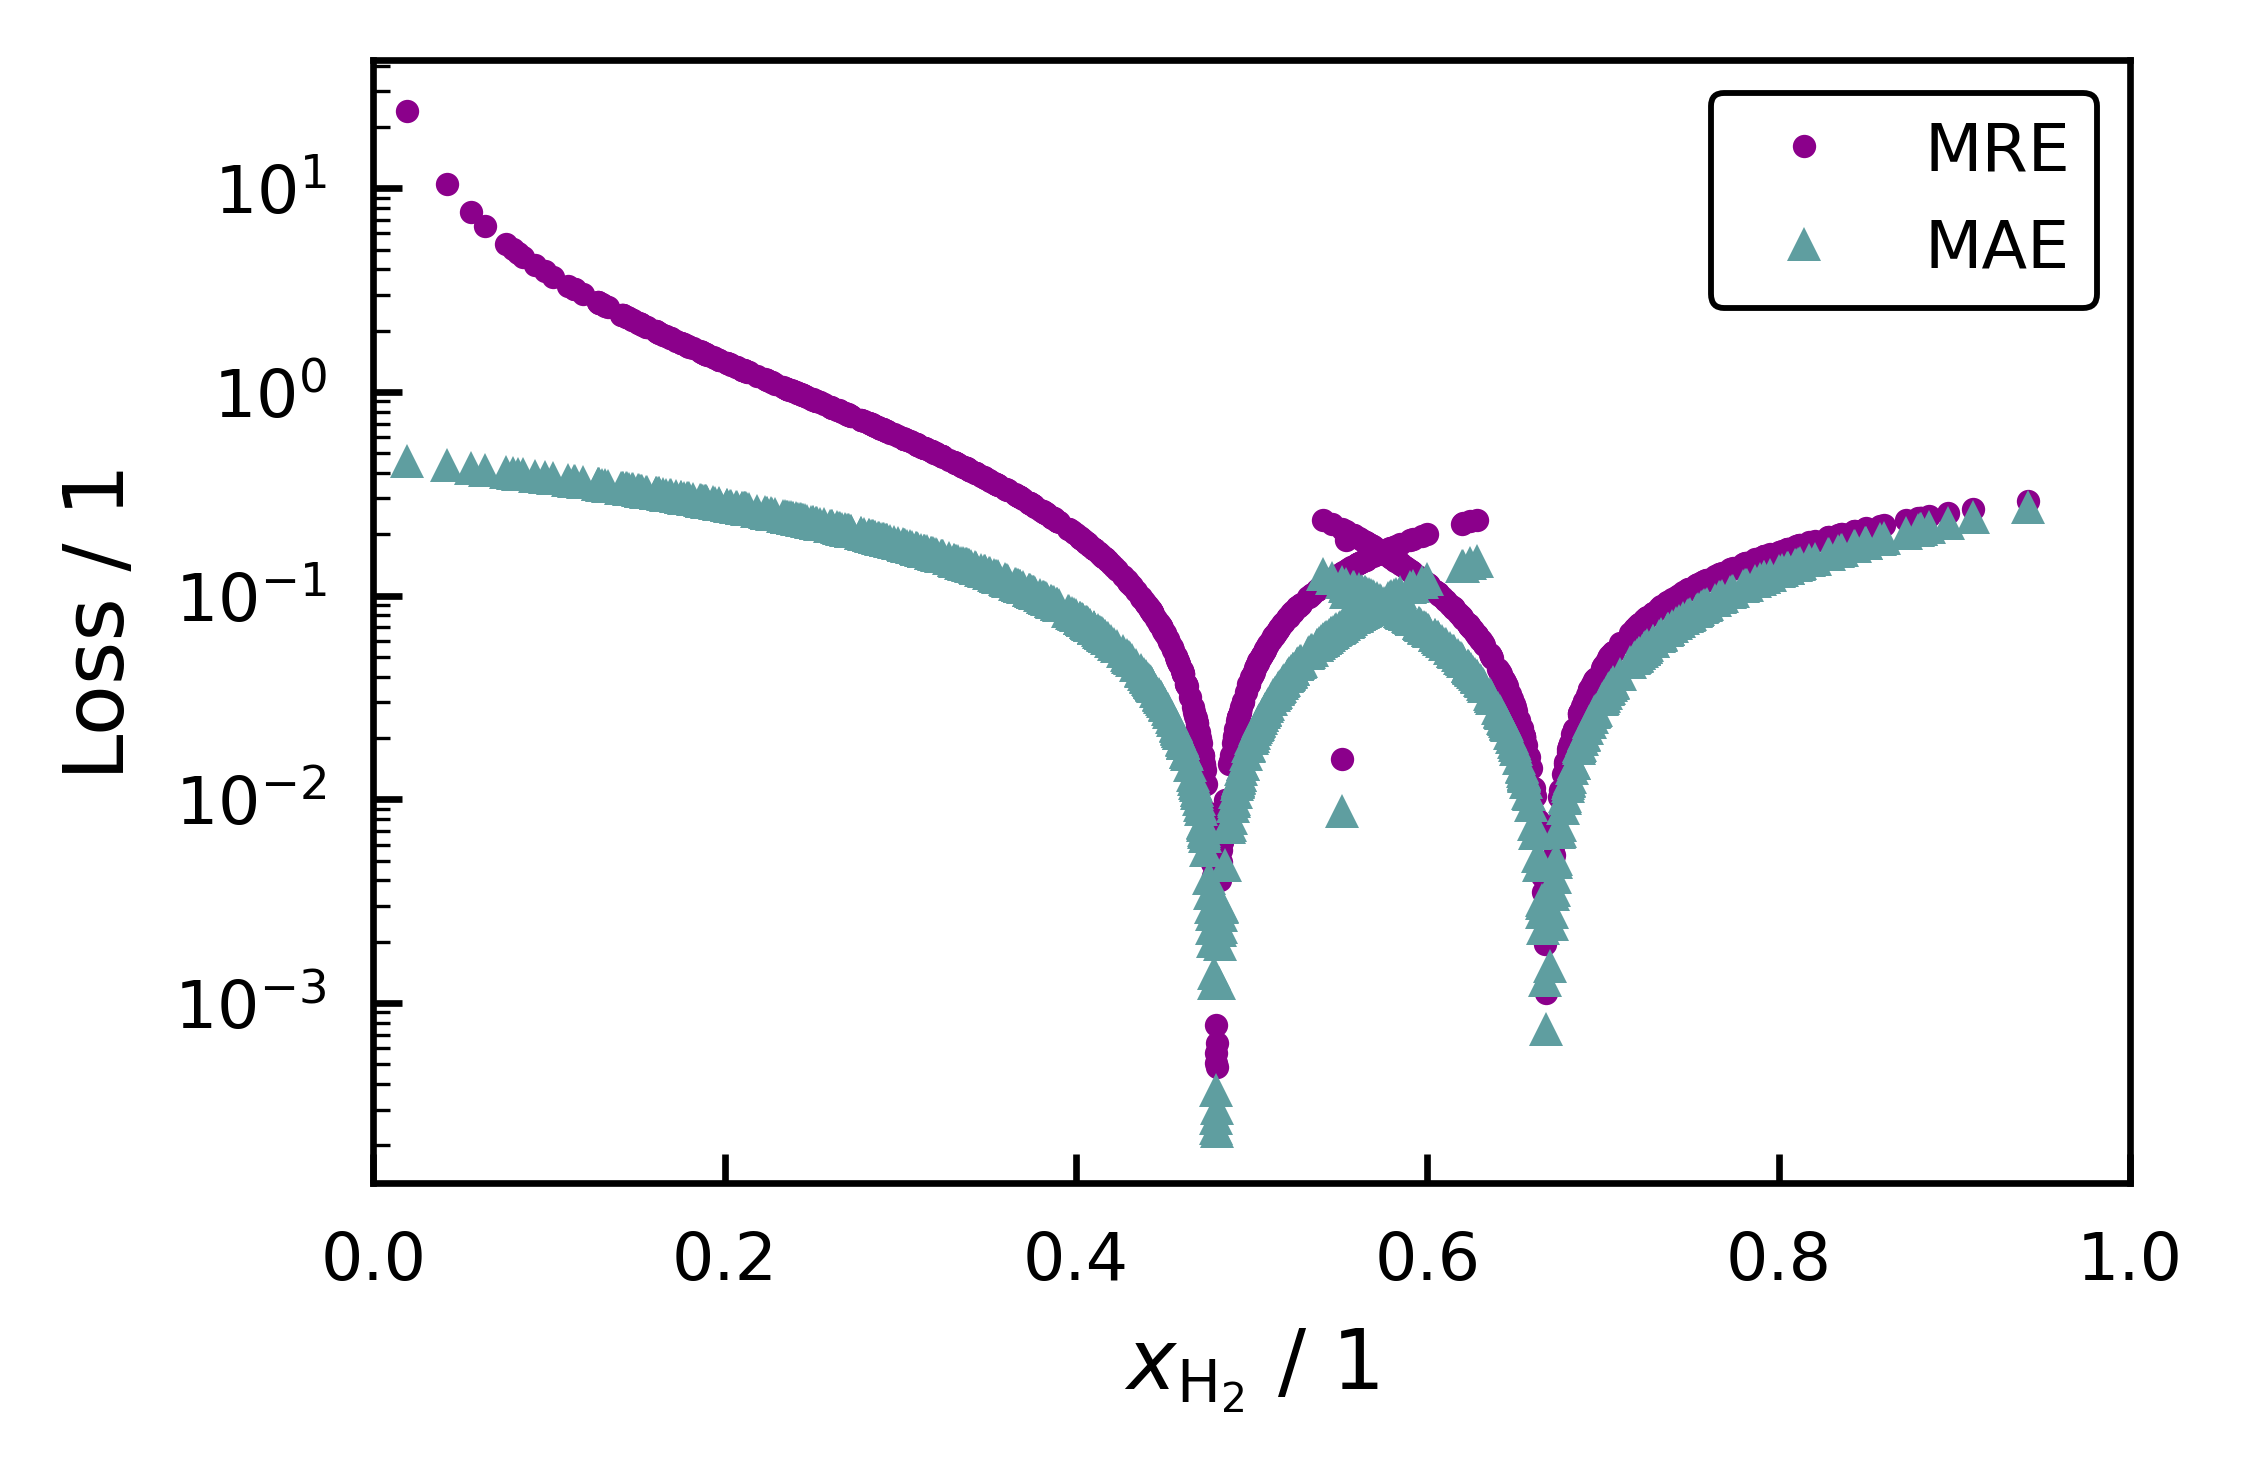

In [17]:
fig,ax = plt.subplots(figsize=(9.75*cm,6.5*cm))
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '^', markersize = 4, label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Loss / 1')
ax.set(xlim=(0,1))
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

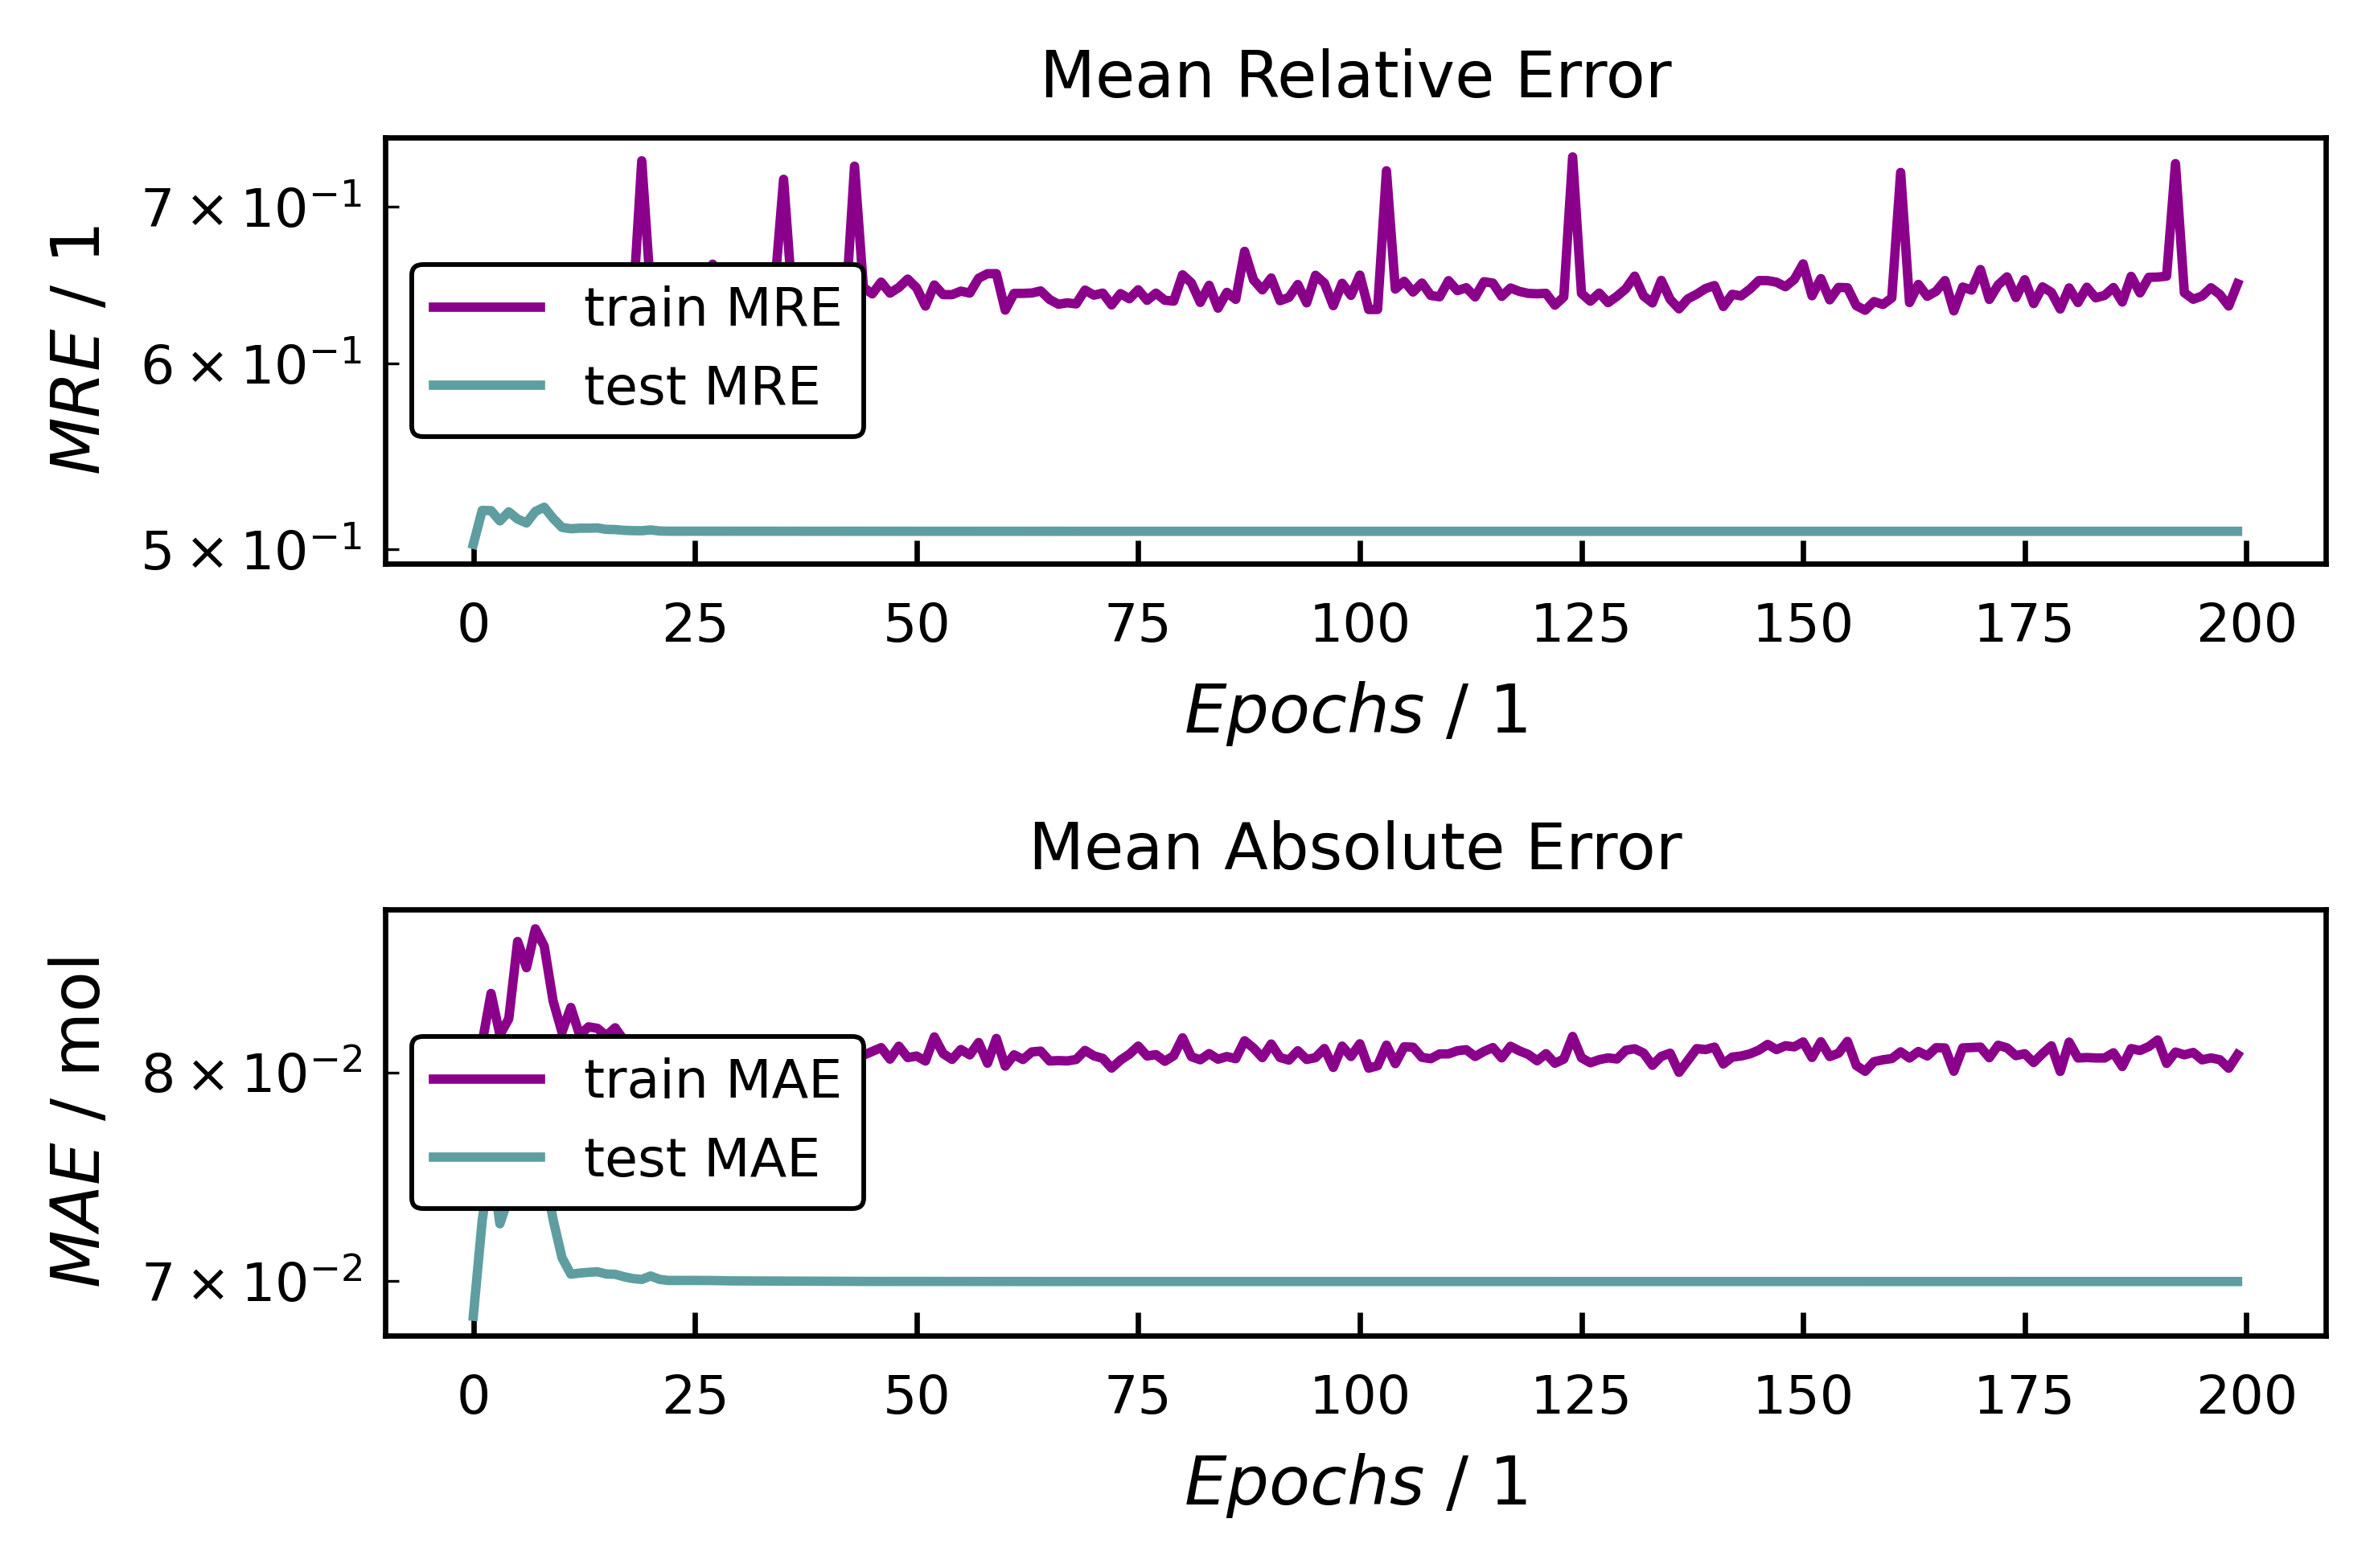

In [18]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

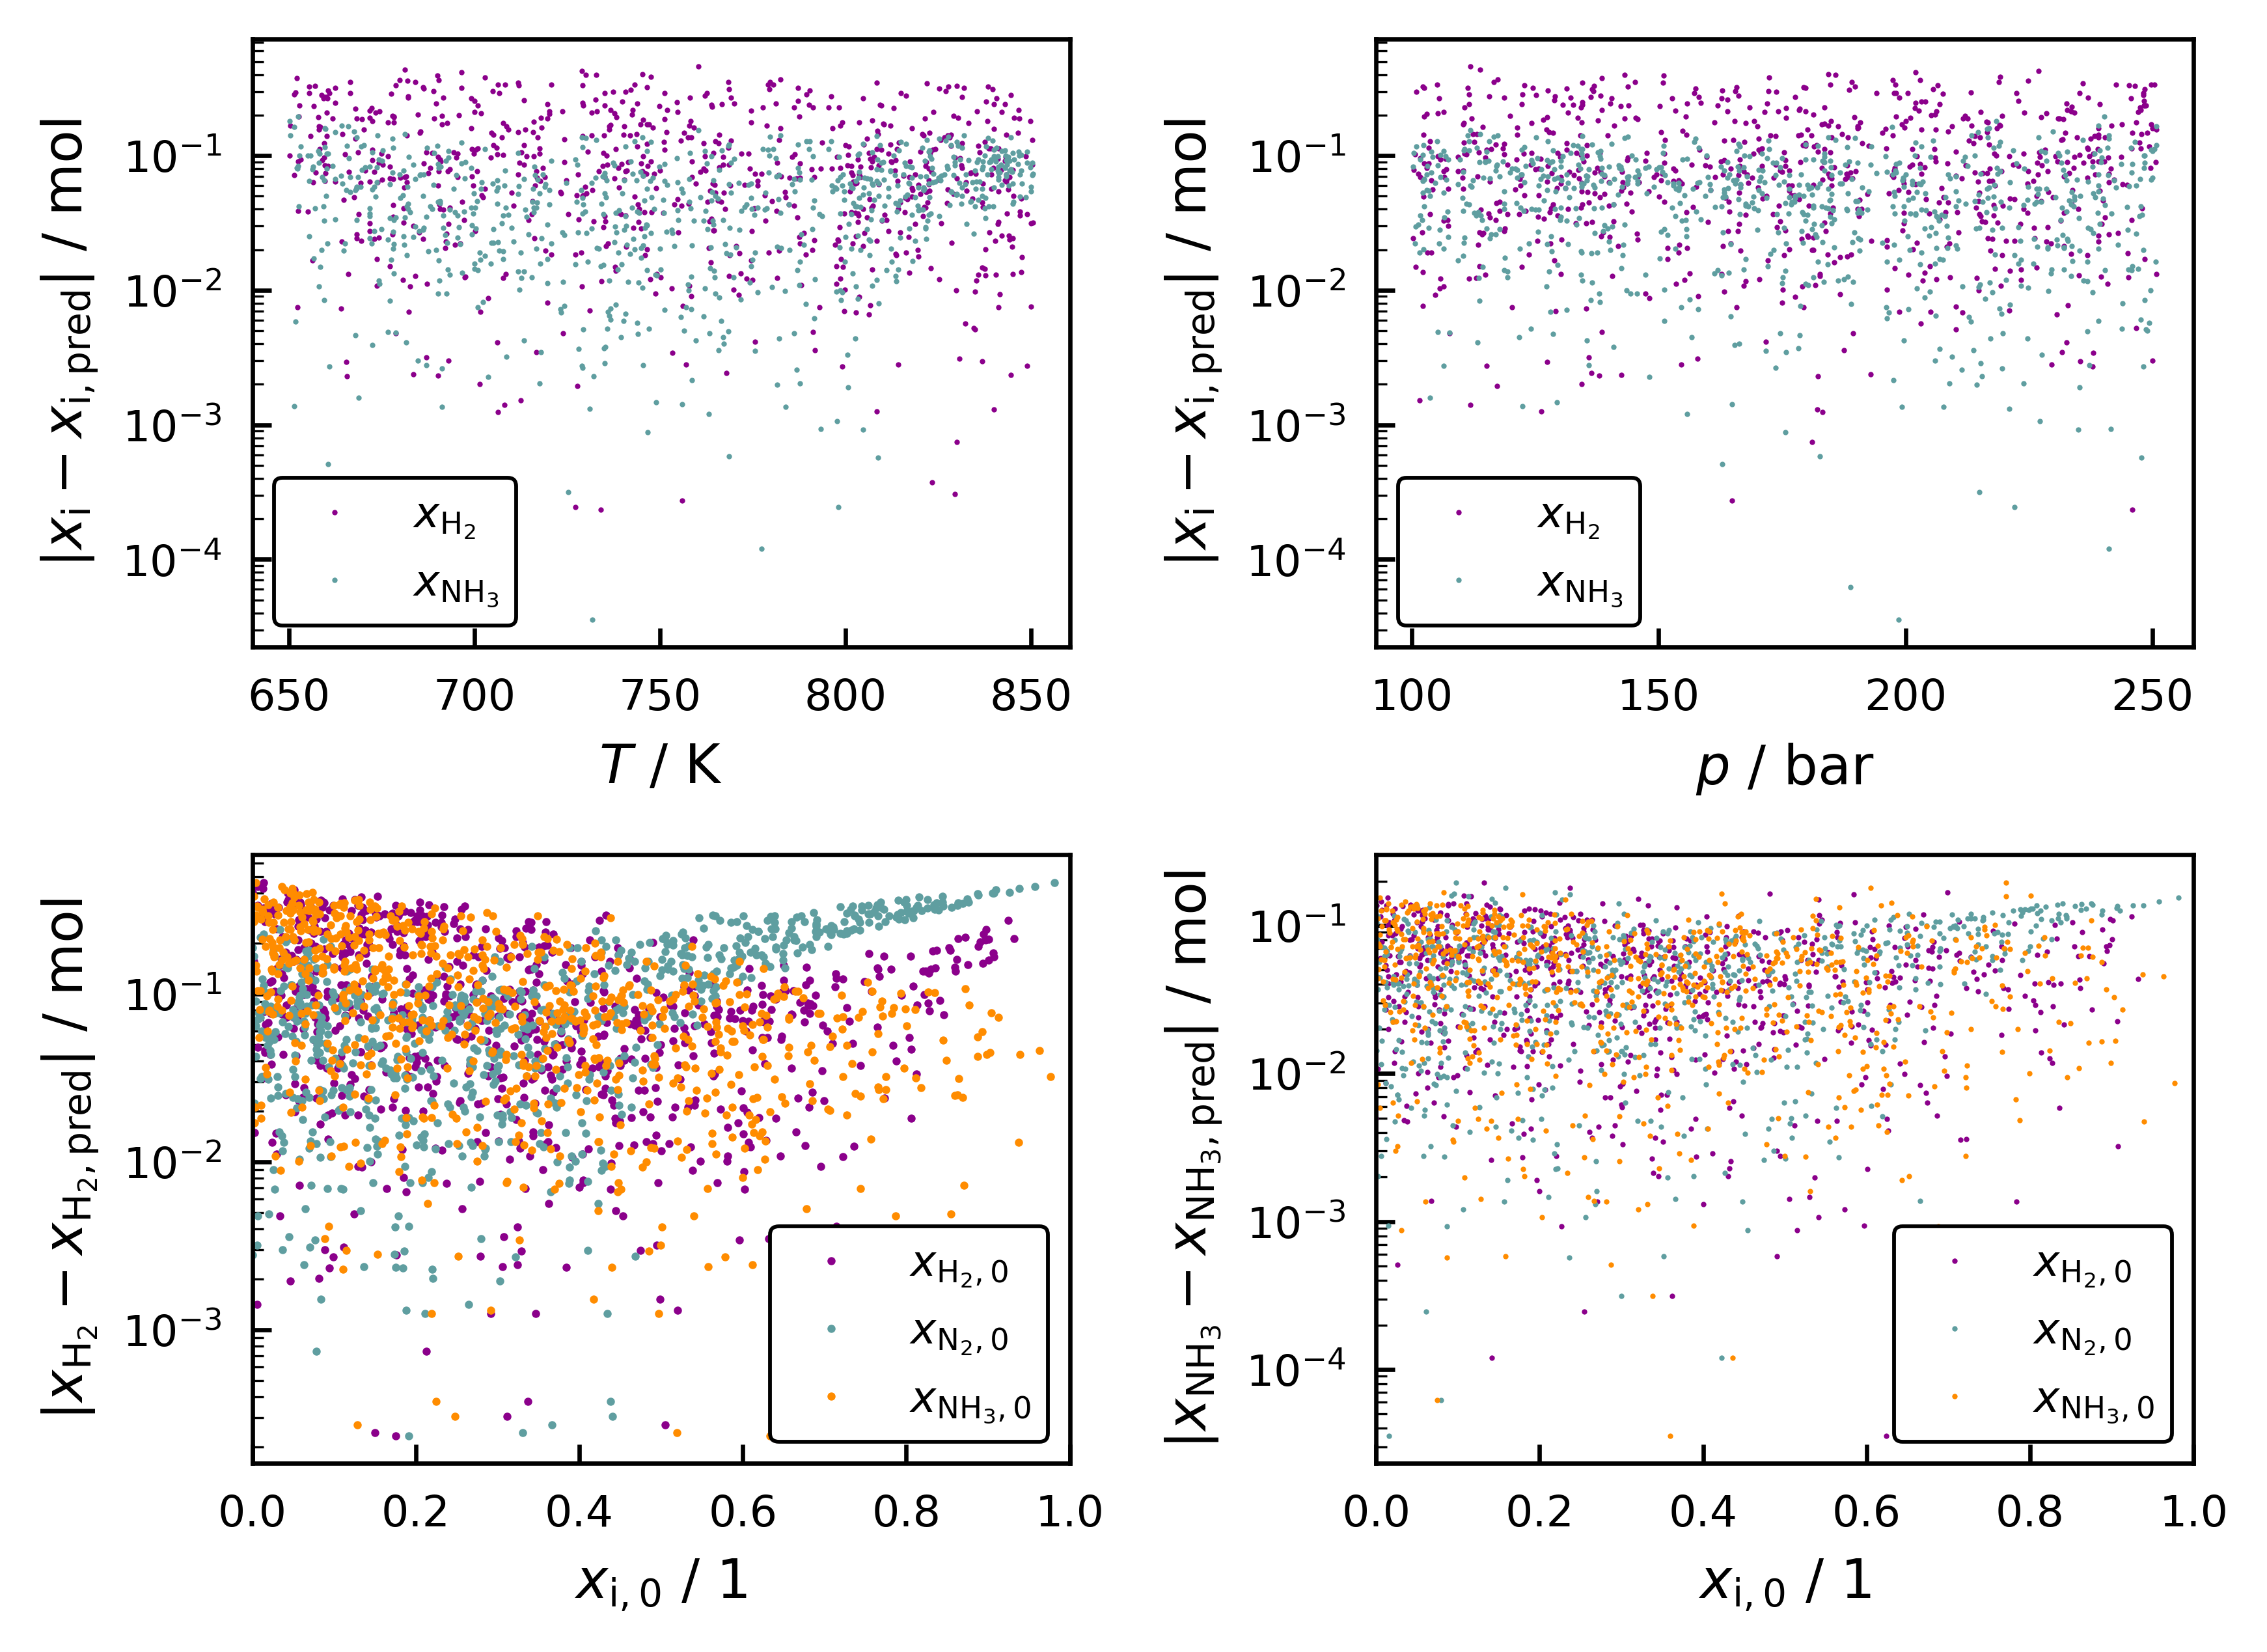

In [19]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (15*cm, 11*cm)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 3, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

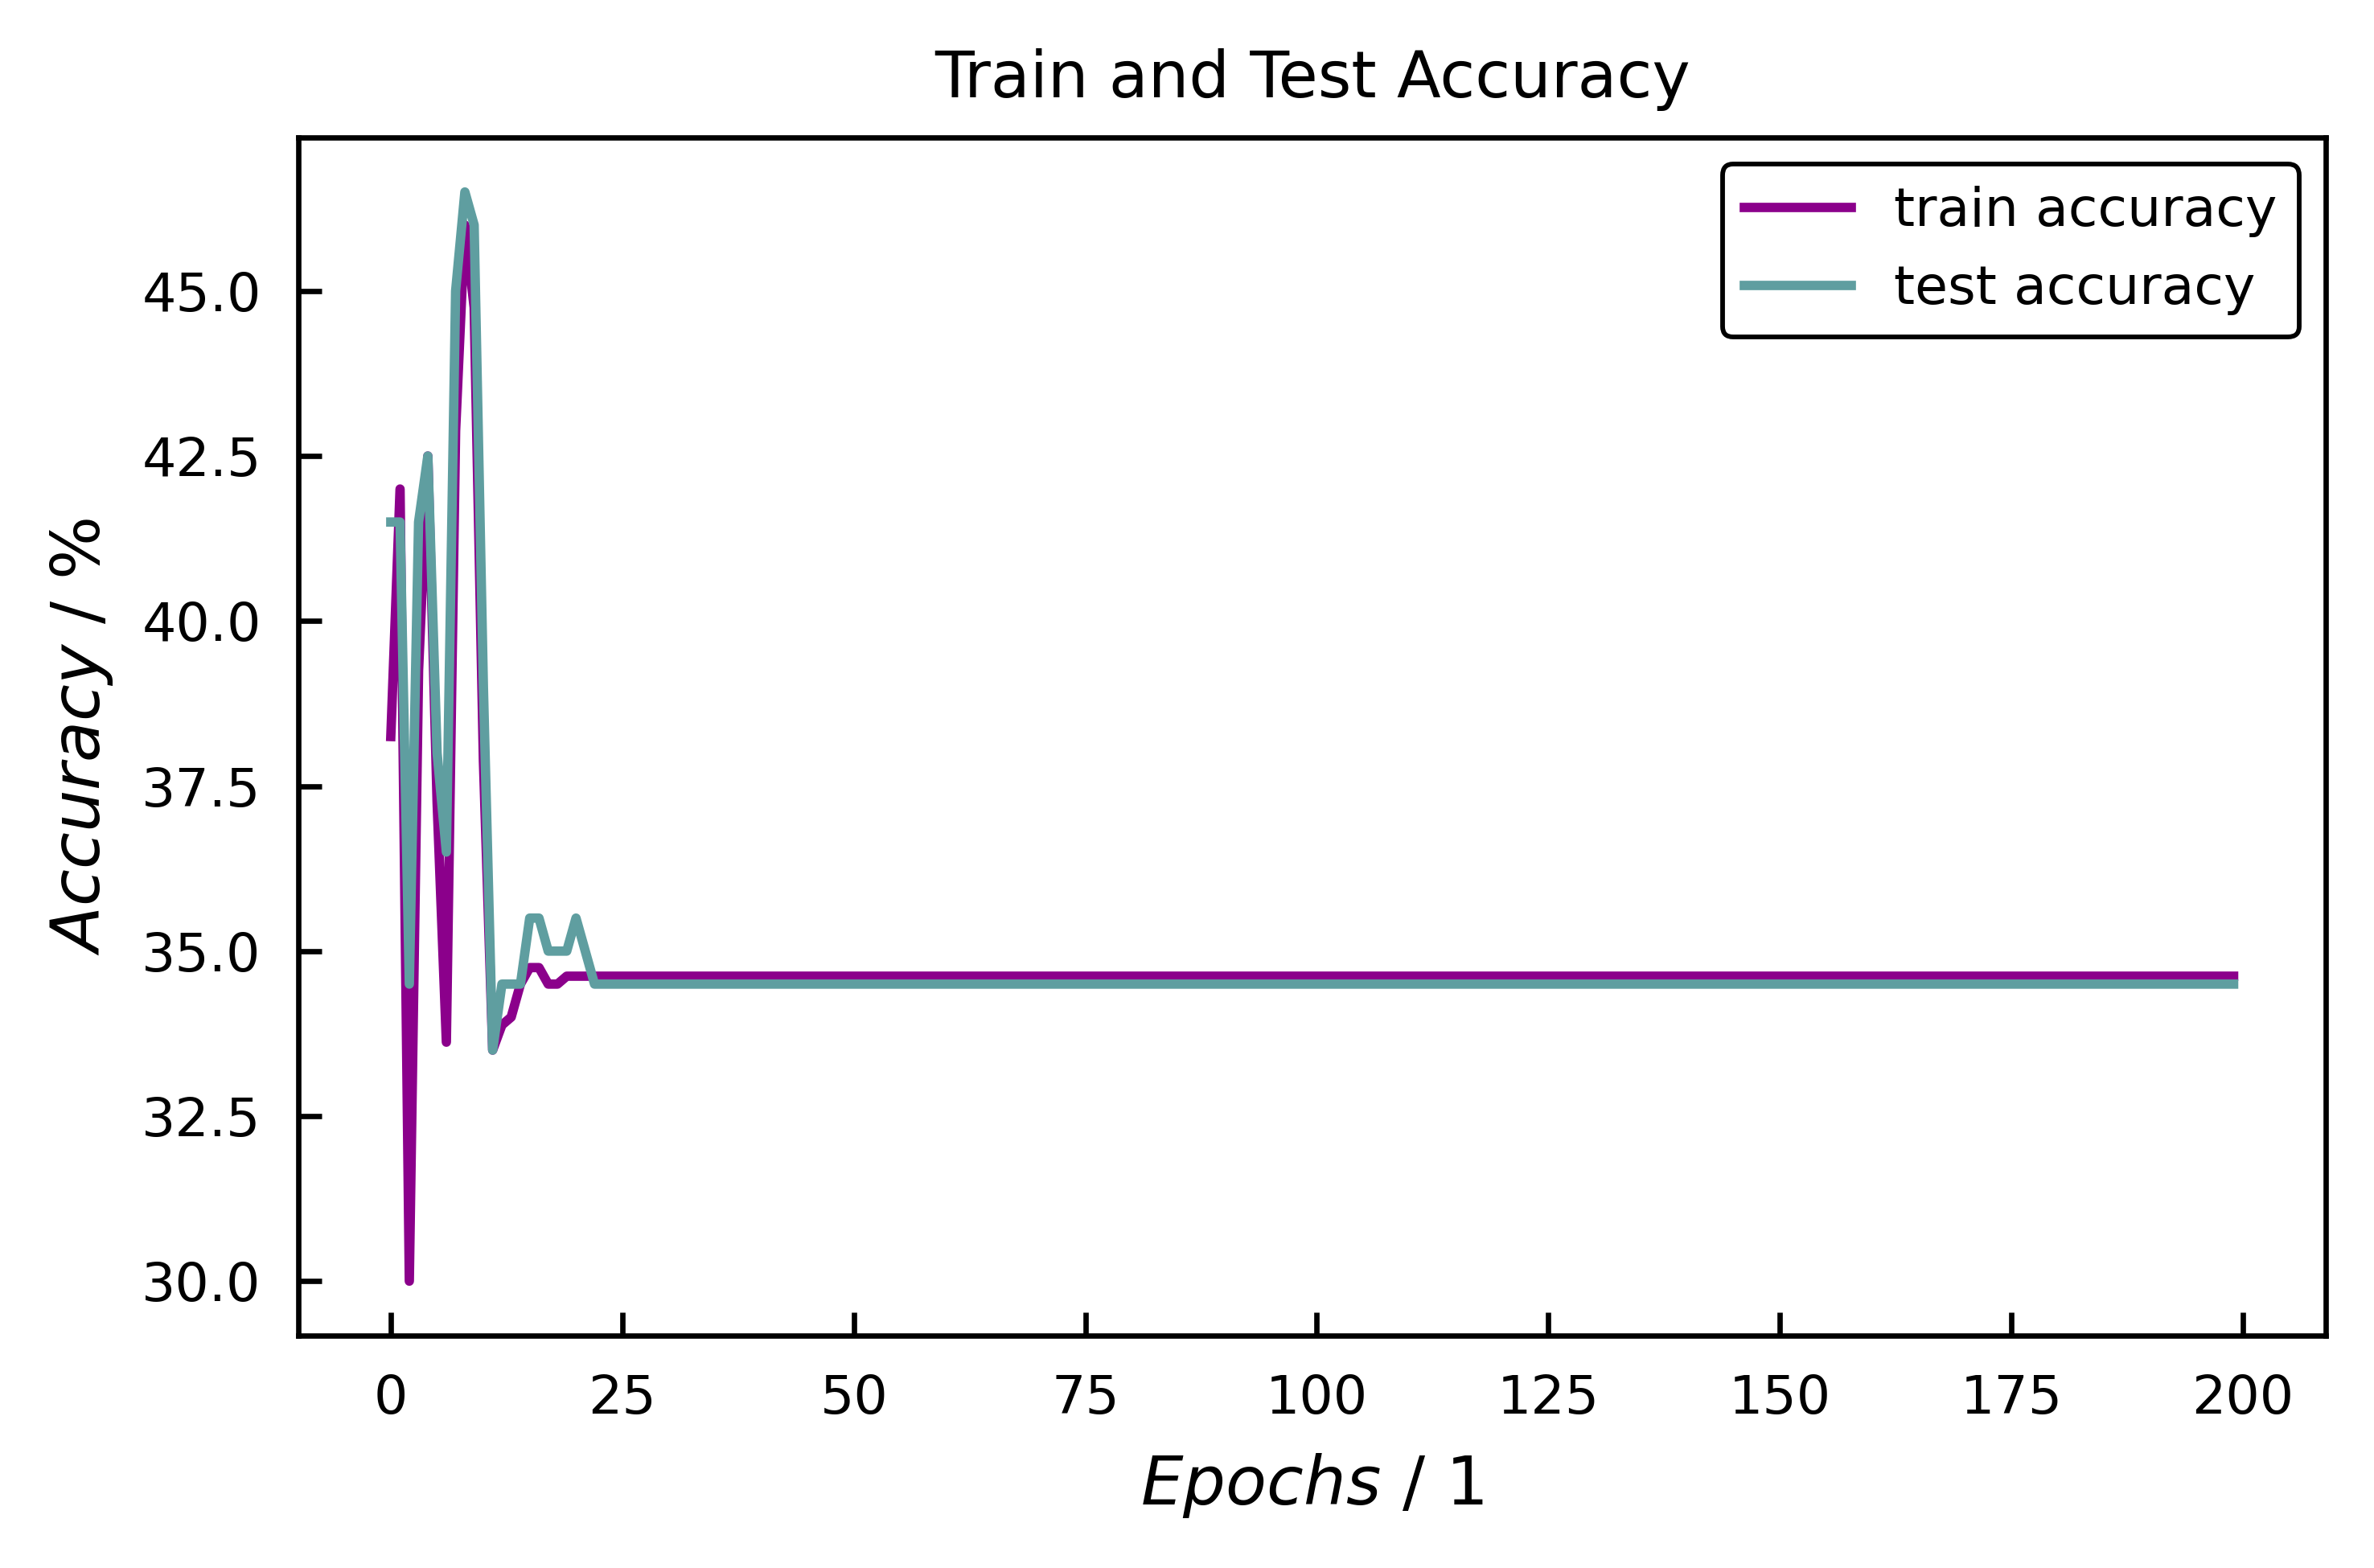

In [20]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [21]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.09375 s


#### Debugging Hilfe

In [22]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 2.1080e-02,  1.6799e+00, -1.4390e+00,  7.1952e-01,  6.7682e-01],
        [-4.2732e-01, -8.7746e-01,  7.8443e-01, -2.2229e-01, -5.4263e-01],
        [ 1.5264e-01, -9.6135e-01,  1.3777e+00, -1.2424e+00, -8.2222e-02],
        [-6.8468e-02, -1.0068e+00, -8.0976e-01, -5.4473e-01,  1.3514e+00],
        [-6.1692e-01, -2.0249e-01,  1.1742e+00,  5.3368e-02, -1.2069e+00],
        [ 7.0154e-01,  1.4541e+00, -1.2064e+00,  1.0880e+00,  7.1903e-02],
        [-2.4635e-01,  7.5125e-01,  1.1552e+00, -1.1599e+00,  5.1801e-02],
        [ 1.6174e+00, -3.9528e-02,  1.4976e+00, -8.5383e-01, -5.9703e-01],
        [-1.0963e+00,  1.4259e+00, -4.2807e-01, -3.2783e-01,  7.5517e-01],
        [ 3.4454e-01, -8.4725e-02,  1.6464e+00, -5.9243e-01, -1.0103e+00],
        [ 8.2211e-01,  4.9447e-02,  8.8542e-01,  3.8255e-01, -1.2599e+00],
        [-3.1635e-01,  1.6484e+00, -1.2782e+00,  1.1253e+00,  1.0428e-01],
        [ 1.2959e+00,  3.6135e-01,  1.6449e+00, -1.1078e+00, -4.8202e-01],
        [ 8.0635e-01,  1.

#### Einblick in Netzwerk

In [23]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-1.9069e-01,  2.5763e-01, -1.9304e-01,  2.8343e-01, -2.1606e-01],
         [-3.4102e-01,  3.1386e-01, -2.0375e-02,  2.2283e-01, -1.1421e-01],
         [ 4.7661e-01, -9.0142e-02,  5.5442e-01, -4.9065e-01,  4.2744e-01],
         [ 1.4981e-01, -2.2726e-01,  3.1732e-01, -6.8655e-02,  3.6791e-01],
         [-6.1821e-01,  3.5516e-01, -1.7045e-01, -2.7508e-01, -5.9143e-02],
         [ 4.9534e-01, -3.0388e-01, -8.8866e-02,  5.9173e-01, -3.9336e-01],
         [-3.8820e-01,  2.6812e-01,  2.3043e-01,  7.9666e-02,  4.2642e-01],
         [ 1.9602e-01,  3.5126e-01,  9.2950e-02,  4.6452e-01, -1.8595e-02],
         [ 6.1115e-01, -1.0276e-01,  2.6719e-01,  4.5571e-01, -3.8114e-01],
         [ 7.1142e-01, -4.4930e-01,  1.7657e-01, -5.3680e-01,  1.1181e-02],
         [ 3.3340e-01, -2.6606e-01, -1.8528e-01,  5.9827e-01, -4.4932e-01],
         [ 3.8989e-01, -8.9447e-02,  5.4920e-01, -2.4377e-01,  4.3126e-01],
         [-3.5296e-03,  9.4528e-03, -5.0885e-01,  6.4832e-01, -5.

In [24]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3322, 0.1004, 0.7216, 0.3476, 0.9026],
        [0.7780, 0.6867, 0.7086, 0.9799, 0.6236]])
tensor([[ 6.7715e-23,  1.3812e-30],
        [ 1.0591e-97, 8.7913e-116]], grad_fn=<SigmoidBackward0>)


In [25]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [26]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.0608, -0.5690,  2.3399, -1.0071, -1.2670],
        [ 0.7401,  1.6670,  1.1262,  0.2861, -1.3977],
        [-1.6737, -0.8804, -0.4265,  1.5954, -1.2121],
        [ 0.2353, -0.2784, -0.5924,  0.9041, -0.3426],
        [ 0.4629, -1.3272, -0.9632,  2.2404, -1.3446],
        [ 0.1093, -0.2494,  1.4727, -0.1235, -1.3191],
        [-0.6538, -0.1485,  1.2918, -1.3779,  0.1406],
        [ 0.0939, -0.9943, -1.2815,  0.6239,  0.6200],
        [ 0.8425,  0.9485, -0.2239,  0.8750, -0.6746],
        [ 0.5022, -0.0502,  1.1812, -1.1257, -0.0087],
        [ 0.4482,  0.8906,  0.8755,  0.0900, -0.9511],
        [ 0.2337,  0.5307, -0.5686,  1.6161, -1.0938],
        [ 0.3567, -1.2205,  0.2952, -1.3373,  1.0771],
        [ 1.1156,  0.3455,  0.1973, -1.1805,  1.0130],
        [-1.5203,  1.7218,  0.6412, -0.9911,  0.3838],
        [ 1.1288,  1.0831, -0.2996, -0.3538,  0.6557],
        [ 0.8819, -0.8620, -1.1970,  1.4515, -0.3089],
        [ 1.0652,  0.7264,  0.4199, -0.0377, -0.3736],
        [ 

#### Histogramme Verteilung von $xi$ und $x{_i}$

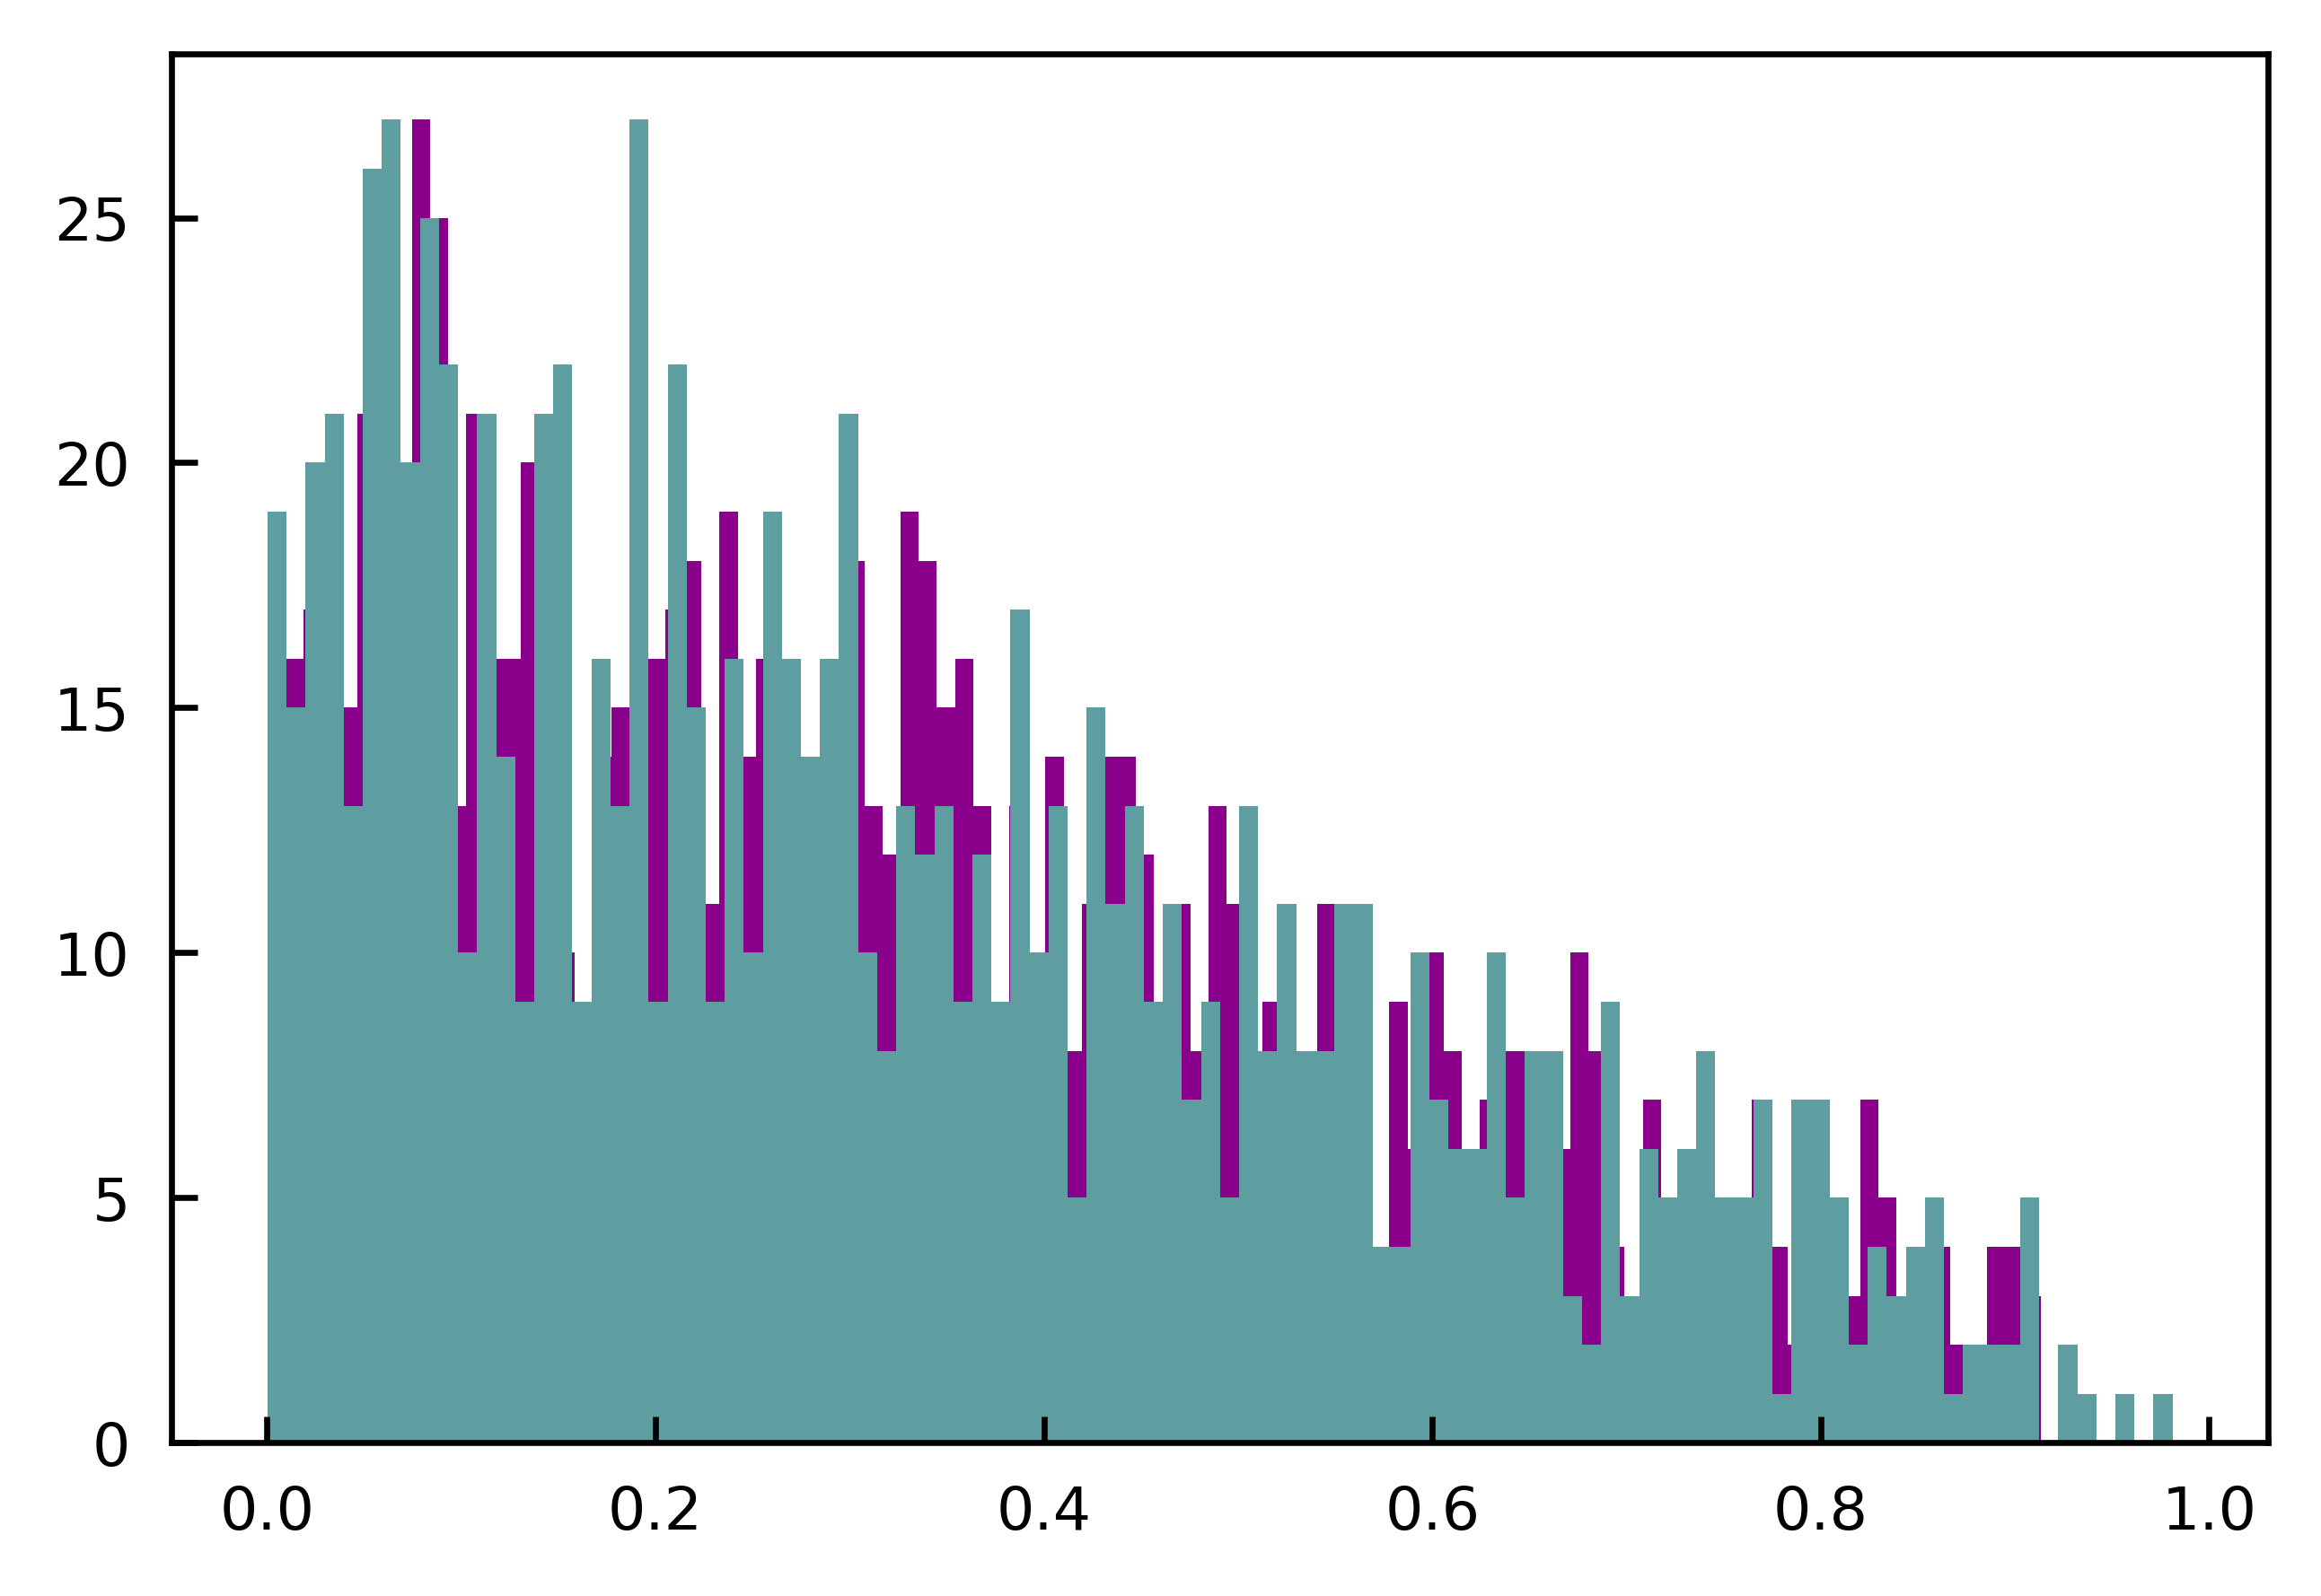

In [27]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [28]:
# torch.save(net.state_dict(),'data/models/ann_005_020_1.pth')
#np.savez('data/models/params_005_020_1.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)